# Final Project Submission

Please fill out:
* Student name: Deztany Jackson
* Student pace: DS Flex
* Scheduled project review date/time: March 23, 2023
* Instructor name: Morgan Jones
* Blog post URL: Dmvinedata.com

In [1]:
"""References for Use:
    Transfer Learning: https://www.youtube.com/watch?v=fj9Y6T7mOyE <br>
    
"""

'References for Use:\n    Transfer Learning: https://www.youtube.com/watch?v=fj9Y6T7mOyE <br>\n    \n'

# Summary- 250 Words
    Business Problem
    Data Understanding
    Data Preparation
    Modeling
    Evaluation
    Conclusion

# Data Understanding


Write a few sentences on the approach to Data Understanding

In [252]:
import os # Getting data 
import glob #Google Collab
#from google.colab import drive #Google Collab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.metrics import AUC, Accuracy,Precision,Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
#from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19 #Pretrained Transfer Modeling
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, f1_score, recall_score,accuracy_score, auc, log_loss
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score, make_scorer
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight #Unsure what this is for
#from sklearn.metrics import plot_precision_recall_curve 
import datetime

import pathlib
import shutil

import warnings
warnings.filterwarnings('ignore')
tf.__version__

import logging
tf.get_logger().setLevel(logging.ERROR)

# Showing the areas of the image
#import lime
#from lime import lime_base
#from lime import lime_image
#from skimage.segmentation import mark_boundaries

In [3]:
#Time
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [4]:

#Current directory
cur_dir = os.getcwd()
cur_dir


'/Users/deztanyjackson/Documents/0_Flatiron/Phase_4/Project_4/Image_Classification_P4'

In [5]:
#Insert description on glob and what is happening

In [6]:
#Puling data in...already know the categories from the problem
train_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/**/*.jpeg'))
val_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/**/*.jpeg'))
test_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/**/*.jpeg'))


print(f"Training Set has: {len(train_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print(f"Testing Set has: {len(test_data)} images")



Training Set has: 4360 images
Validation Set has: 872 images
Testing Set has: 624 images


In [7]:
DIR = "../chest_xray/"
sets = ["train", "val", "test"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print(f"Ratio of Normal/Pneumonia: {round(len(all_normal)/len(all_pneumonia),2)}")


Total Pneumonia Images: 4273
Total Normal Images: 1583
Ratio of Normal/Pneumonia: 0.37


In [8]:
#Pulling in Normal and Pneumonia specific data
v_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/PNEUMONIA/*.jpeg'))
v_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/NORMAL/*.jpeg'))
t_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
t_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))
test_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/NORMAL/*.jpeg'))
test_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/PNEUMONIA/*.jpeg'))

### Initial Data Balancing 

- Orinally started with 16 Validation Images
- Moving validation images to train set.
- Perform Random Train/Valid split 80/20 on Normal and Pneumonia images
- Move 20% of each back to validation folder

NameError: name 'fl_score' is not defined

In [9]:
#Moving Validation to Test
cat = [v_norm,v_pneu]

for c in cat:
    if c == v_norm:
        images = [f for f in v_norm if '.jpeg' in f.lower()] 
        for img in images:
            new_path = os.path.join(cur_dir,"data/chest_xray/train/NORMAL/")
            shutil.move(img,new_path)
    elif c == v_pneu:
        images = [f for f in v_pneu if '.jpeg' in f.lower()] 
        for img in images:
            new_path = os.path.join(cur_dir,"data/chest_xray/train/PNEUMONIA/")
            shutil.move(img,new_path)
    else:
        pass


In [10]:
train_cat = [t_norm,t_pneu]

for cat in train_cat:
    train,val = train_test_split(cat, train_size=.8, random_state=42)
    if cat == t_norm:
        for img in val:
            new_path = os.path.join(cur_dir,"data/chest_xray/val/NORMAL/")
            shutil.move(img,new_path)
    elif cat == t_pneu:
        for img in val:
            new_path = os.path.join(cur_dir,"data/chest_xray/val/PNEUMONIA/")
            shutil.move(img,new_path)
    else:
        pass
    

In [11]:
v_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/PNEUMONIA/*.jpeg'))
v_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/NORMAL/*.jpeg'))
t_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
t_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))
test_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/NORMAL/*.jpeg'))
test_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/PNEUMONIA/*.jpeg'))

In [12]:

print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")


Training Set has: 4360 images
Testing Set has: 624 images
Validation Set has: 872 images


In [13]:
print(f"Validation Pneumonia Amount: {len(v_pneu)} images")
print(f"Validation Normal Amount: {len(v_norm)} images")
print(f"Validation Normal to Pneumonia Ratio: {round(len(v_norm)/len(v_pneu),2)}")


Validation Pneumonia Amount: 648 images
Validation Normal Amount: 225 images
Validation Normal to Pneumonia Ratio: 0.35


There is still imbalance but better offset.

### Graph of Pneumonia to Normal count (All, Train, Val, Test)

In [14]:
# Will do

### Normal and Pneumonia Images

<b> NORMAL IMAGES

Sample of Random Normal Pictures


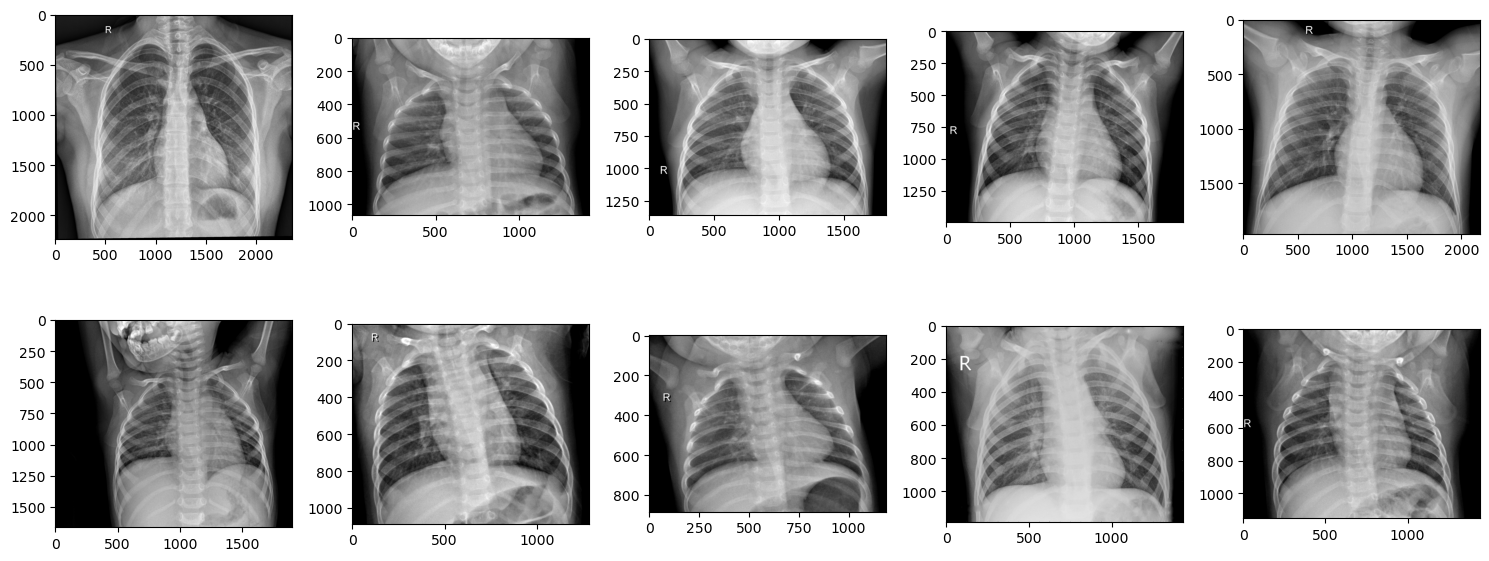

In [330]:
plt.figure(figsize = (15,15))
print ("Sample of Random Normal Pictures")
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread(t_norm[i])
    plt.imshow(img, cmap = "gray")
    plt.tight_layout()
    #plt.axis('off')

<b> PNEUMONIA IMAGES

Sample of Random Pneumonia Pictures


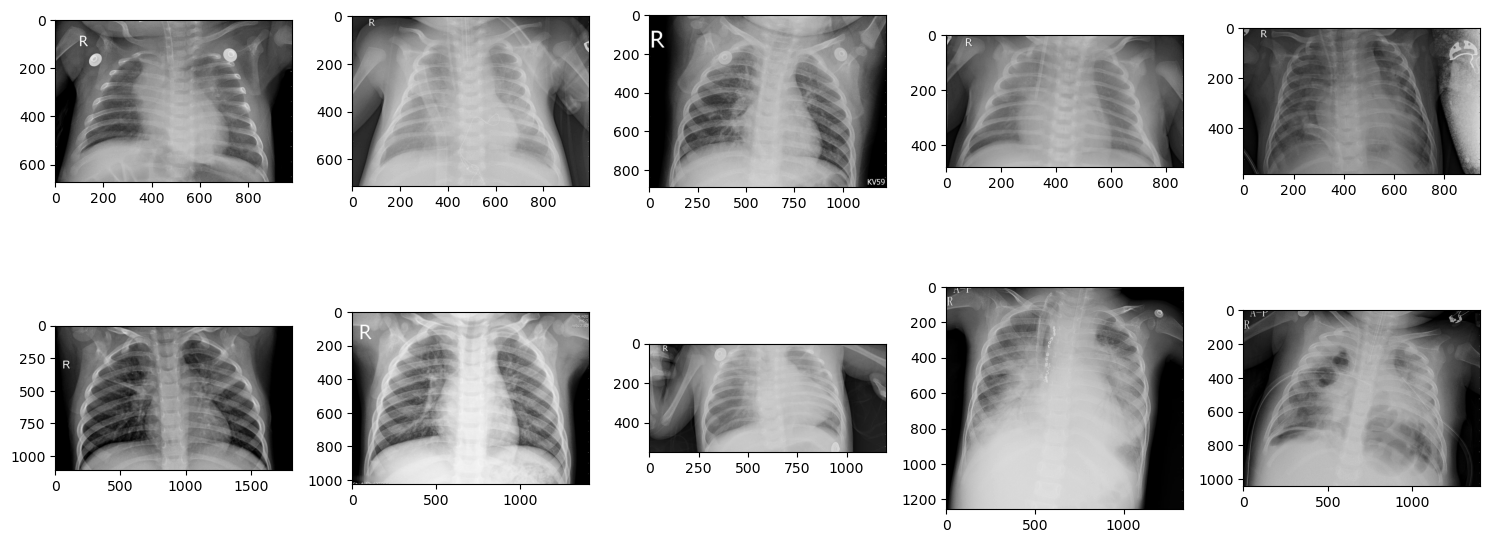

In [331]:
plt.figure(figsize = (15,15))
print ("Sample of Random Pneumonia Pictures")
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread(t_pneu[i])
    plt.imshow(img, cmap = "gray")
    plt.tight_layout()
    #plt.axis('off')

Visually, both the Normal and Pneumonia pictures vary in size. Pneumonia pictures have a cloudier look.

## Preprocessing Images

#Rescaling the image [Rescaling](https://datascience.stackexchange.com/questions/92499/rescale-parameter-in-data-augmentation#:~:text=As%20rightly%20pointed%20out%20by,evenly%20to%20the%20total%20loss)

In [17]:
#ImageDataGenerator without pre data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
#Current Directories
train_directory= 'data/chest_xray/train'
validation_directory= 'data/chest_xray/val'
test_directory = 'data/chest_xray/test'


### Image Generator

Describe:
- Target Size
- Batch Size
- Class Mode
- Shuffle

In [19]:
#Using a generator for the images to work with.
train_gen = train_datagen.flow_from_directory(train_directory,
                                                   target_size = (224, 224),
                                                   batch_size=64,
                                                   classes = ["NORMAL","PNEUMONIA"],
                                                   class_mode = 'binary',
                                                   
                                                   seed = 42)

val_gen = val_datagen.flow_from_directory(validation_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 32,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42)
test_gen = test_datagen.flow_from_directory(test_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 32,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42,
                                                      shuffle= False)                                                      

Found 4359 images belonging to 2 classes.
Found 873 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [20]:
#Checking the class label and index match
print(train_gen.class_indices)
print(val_gen.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


Iterating through the generated images.
X and y are the images and labels respectively. It is a sample equal to the batch size above.

In [21]:
X_train, y_train = next(train_gen)
X_test, y_test = next(test_gen)
X_val, y_val = next(val_gen)

In [22]:
"""# Plot the count fo the Pneumonia for All and Training using the X and y

labels = [ "Pneumonia", "Normal"]
values = [len(all_pneumonia), len(all_normal) ]
colors = ["orange", "blue"]
print(values)
sns.countplot(x = values, label = labels)

#Distribution of Category Variables
fig,ax=plt.subplots(figsize=(8,8), facecolor = "white")
sns.countplot(x = "Category", data=train_gen)
plt.title('Distribution of Categories on Data')
plt.grid(axis = "y")
plt.show()
fig.savefig("images/dist.png", dpi=150)"""

'# Plot the count fo the Pneumonia for All and Training using the X and y\n\nlabels = [ "Pneumonia", "Normal"]\nvalues = [len(all_pneumonia), len(all_normal) ]\ncolors = ["orange", "blue"]\nprint(values)\nsns.countplot(x = values, label = labels)\n\n#Distribution of Category Variables\nfig,ax=plt.subplots(figsize=(8,8), facecolor = "white")\nsns.countplot(x = "Category", data=train_gen)\nplt.title(\'Distribution of Categories on Data\')\nplt.grid(axis = "y")\nplt.show()\nfig.savefig("images/dist.png", dpi=150)'

# Modeling


### Custom Functions for Modeling


[Visualization Metrics,A.Jang 2023](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays#8.-Visualizing-model-performance)

In [23]:
def eval_metrics(history):
    """ Enter Docstring information Plotting the accuracy and the loss of the training and validation model"""
    
    fig, ax = plt.subplots(1,4, figsize = (25,5))
    fig.suptitle('Model Metrics Results')
    
    metrics = ["acc","loss","recall","precision"]   
    
    for i, metric in enumerate(metrics):
    
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history["val_" + metric])
        ax[i].set_title('Model {}'.format(metric))
        ax[i].set_ylabel(metric)
        ax[i].set_xlabel("Epochs")
        ax[i].legend(['train', 'val'])

        

[Predictor Algorithm with Shuffle,by Jakob, 2021](https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator/67282636#67282636)

In [24]:
def predict_results(model, generator):
    """Generator with shuffle = True"""
    
    # Create lists for storing the predictions and labels
    predictions = []
    labels = []

    # Get the total number of labels in generator 
    # (i.e. the length of the dataset where the generator generates batches from)
    n = len(generator.labels)

    # Loop over the generator
    for data, label in generator:
        # Make predictions on data using the model. Store the results.
        predictions.extend(model.predict(data).flatten())

        # Store corresponding labels
        labels.extend(label)

        # We have to break out from the generator when we've processed 
        # the entire once (otherwise we would end up with duplicates). 
        if (len(label) < generator.batch_size) and (len(predictions) == n):
            break
        return labels, predictions #y_true, y_hat_train/y_pred

In [25]:
def conf_matrix(y_true,y_pred, norm_bool):
    
    y_pred = np.round(y_pred,0) #Rounding to the nearest 0 or 1, assumes threshold is >.5 for
    cmatrix= cm(y_true, y_pred, normalize=norm_bool)
    matrix_disp= ConfusionMatrixDisplay(cmatrix, display_labels= ["NORMAL", "PNUEMONIA"])
    matrix_disp.plot()

    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Model Confusion Matrix')
    plt.show()
    

28/28 [==============================] - 3s 110ms/step - loss: 0.1060 - acc: 0.9714 - recall: 0.9799 - precision: 0.9815


[0.106011301279068, 0.9713631868362427, 0.979938268661499, 0.9814528822898865]

In [314]:
def eval_report(y_true, y_pred,gen,history):
    
    y_pred = np.round(y_pred,0) # Rounding to the nearest 0 or 1
    #Display Precision, Recall, F1 and Accuracy
    print(classification_report(y_true, y_pred))
    print('\n')
    
    #Display Model Metrics
    loss, acc, recall, precision = history.model.evaluate(gen)
    print(f'Loss: {loss}')


In [27]:
# set up the class weights using y_train
def calc_weight(labels):
    """ Setting the weights and pairing it with the classes for the class weight paramters in model.fit. 
    Labels can also be thought of as y_train"""
    classes = [0,1]
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights = dict(zip(classes, weights))
    return class_weights

In [28]:
#If needed create plots
# def plot_roc_auc():
# def plot_precision_recall():

Write out the layout of each modeling iteration
- sequence <br>
- compile <br>
- summary <br>
- fit <br>
- predict <br>
- conf_matrix <br>
- eval report <br>
- Each iteration will have slight changes for improvement.  They will be described more at the
- General descriptions of  iterations

# Baseline Modeling (1)

Describe the main model hyperparameters and data parameters
- model sequence layers, filter, activation 



In [29]:
baseline = models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='sigmoid'),    
Dense(units=1, activation='sigmoid'),
])

Metal device set to: Apple M2 Max


2023-03-25 15:51:55.111326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-25 15:51:55.111461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [30]:
#Compile
baseline.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"])

In [31]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 96)       0

In [32]:
#describe the learned parameters in summary - DeepLizard

In [33]:
#Fit
history = baseline.fit(train_gen,
                       epochs=10,
                       verbose = 2,
                       validation_data=val_gen)

Epoch 1/10


2023-03-25 15:51:55.517419: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-25 15:51:55.972245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-25 15:52:12.509906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 - 20s - loss: 0.3120 - acc: 0.8720 - recall: 0.9354 - precision: 0.8966 - val_loss: 0.2008 - val_acc: 0.9233 - val_recall: 0.9923 - val_precision: 0.9121 - 20s/epoch - 294ms/step
Epoch 2/10
69/69 - 19s - loss: 0.1121 - acc: 0.9582 - recall: 0.9768 - precision: 0.9672 - val_loss: 0.1212 - val_acc: 0.9565 - val_recall: 0.9552 - val_precision: 0.9857 - 19s/epoch - 268ms/step
Epoch 3/10
69/69 - 19s - loss: 0.0821 - acc: 0.9702 - recall: 0.9799 - precision: 0.9799 - val_loss: 0.1104 - val_acc: 0.9576 - val_recall: 0.9707 - val_precision: 0.9722 - 19s/epoch - 270ms/step
Epoch 4/10
69/69 - 19s - loss: 0.0701 - acc: 0.9745 - recall: 0.9839 - precision: 0.9818 - val_loss: 0.1107 - val_acc: 0.9633 - val_recall: 0.9676 - val_precision: 0.9828 - 19s/epoch - 271ms/step
Epoch 5/10
69/69 - 19s - loss: 0.0765 - acc: 0.9716 - recall: 0.9802 - precision: 0.9814 - val_loss: 0.1091 - val_acc: 0.9691 - val_recall: 0.9722 - val_precision: 0.9859 - 19s/epoch - 270ms/step
Epoch 6/10
69/69 - 19s - loss: 

<b> Baseline Metrics

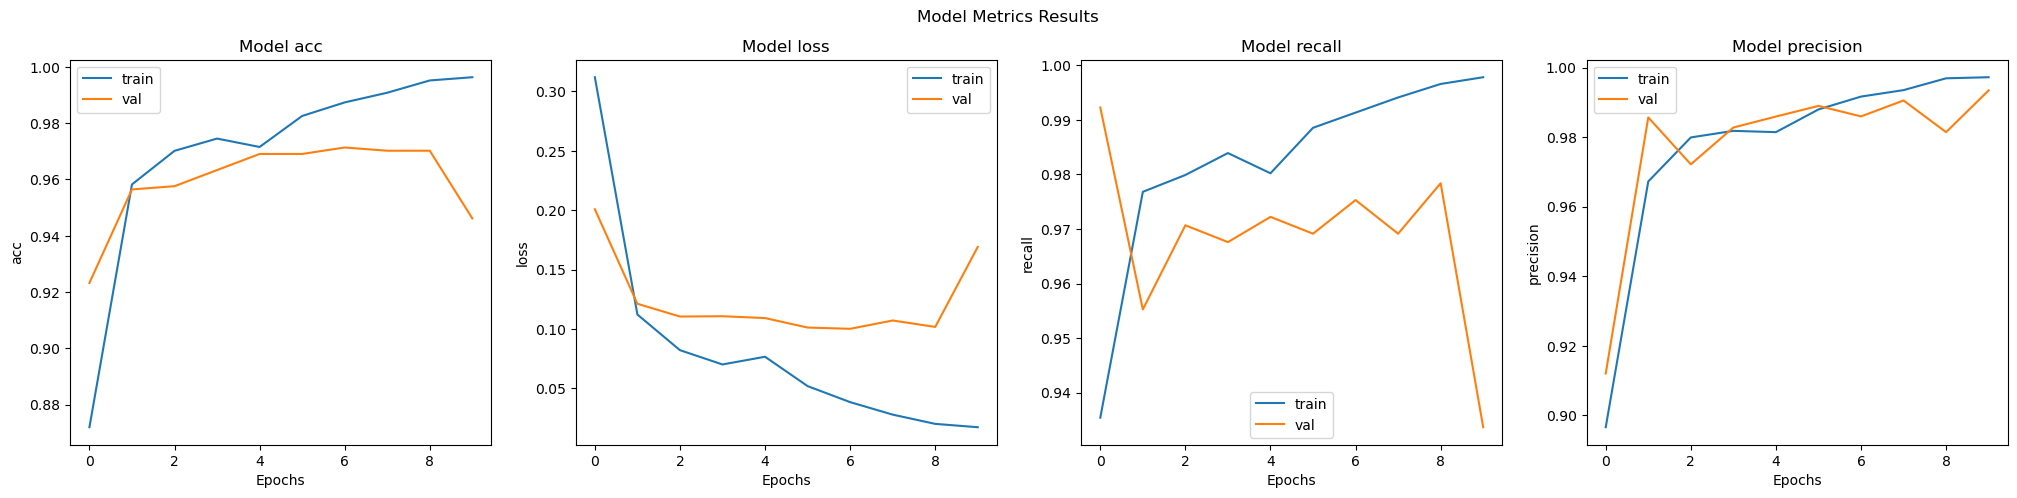

In [34]:
#Plotting chosen metrics V
eval_metrics(history)

In [35]:
train_labels, train_predictions = predict_results(baseline,train_gen)
val_labels, val_predictions = predict_results(baseline,val_gen)

2/2 [==============================] - 0s 28ms/step


2023-03-25 15:55:04.271152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


Training Confusion Matrices:



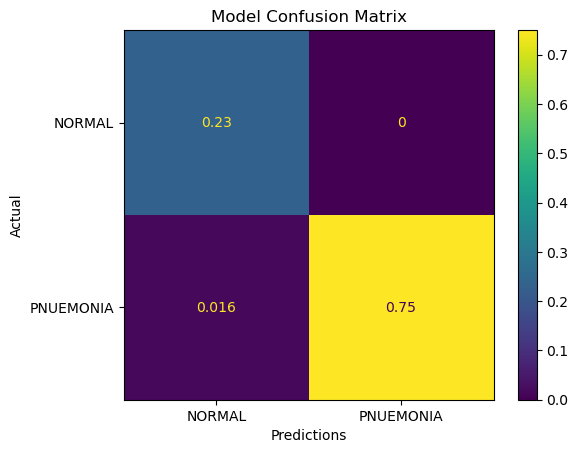

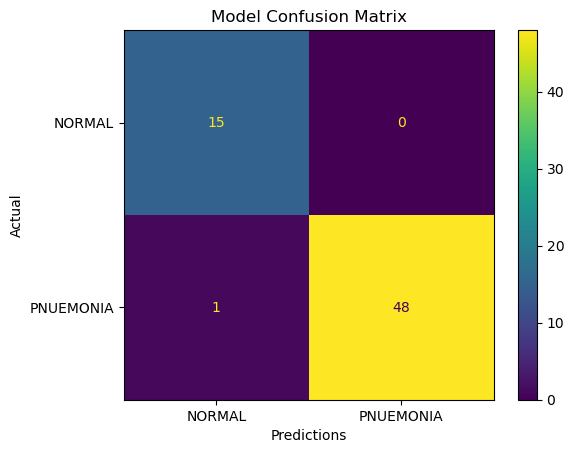

Validation Confusion Matrices:



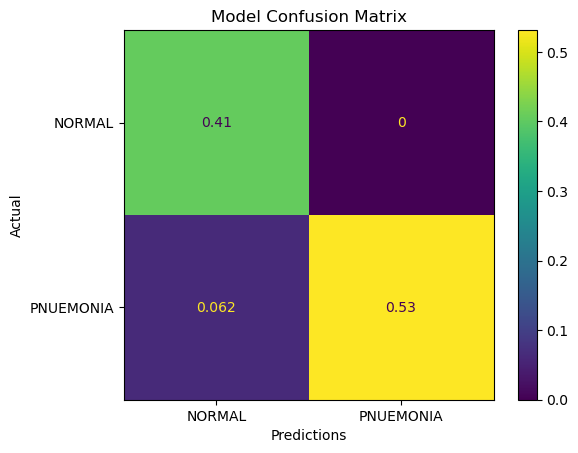

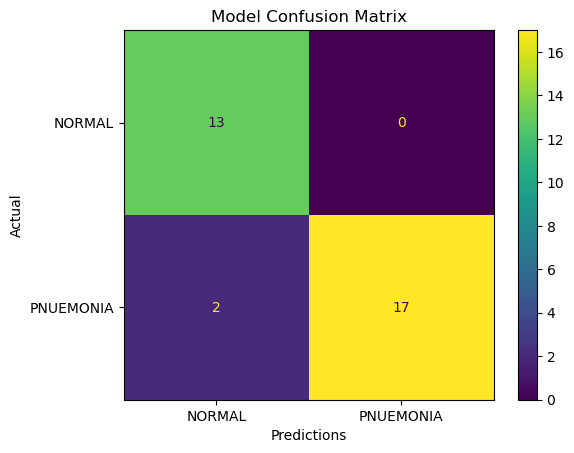

In [36]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, "all")
conf_matrix(train_labels,train_predictions, None)
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, "all")
conf_matrix(val_labels, val_predictions, None)

In [308]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        15
         1.0       1.00      0.98      0.99        49

    accuracy                           0.98        64
   macro avg       0.97      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64



69/69 [==============================] - 15s 218ms/step - loss: 0.0643 - acc: 0.9713 - recall: 0.9626 - precision: 0.9987
Loss: 0.06428426504135132


In [309]:
#Validation Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95         9
         1.0       1.00      0.96      0.98        23

    accuracy                           0.97        32
   macro avg       0.95      0.98      0.96        32
weighted avg       0.97      0.97      0.97        32



28/28 [==============================] - 3s 107ms/step - loss: 0.1691 - acc: 0.9462 - recall: 0.9336 - precision: 0.9934
Loss: 0.16905631124973297


Epoch 4 Diverging

# Baseline Model with Class Weights 

Adding class weights to see it helps with class imbalance.


In [39]:

baseline2 = models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='sigmoid'),    
Dense(units=1, activation='sigmoid'),
])

In [40]:
#Run the others the sames as the baseline and look at the results...What is your assessment? Make an action

In [41]:
baseline2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"]
                 )

In [42]:
#Calculating class weights for imbalance
class_weights = calc_weight(y_train)
class_weights

{0: 1.5238095238095237, 1: 0.7441860465116279}

In [43]:
history2 = baseline2.fit(train_gen,
                       epochs=1,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen)

Epoch 1/10


2023-03-25 15:55:24.333889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-25 15:55:39.776883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 - 19s - loss: 0.3133 - acc: 0.8568 - recall: 0.8683 - precision: 0.9342 - val_loss: 0.2543 - val_acc: 0.9015 - val_recall: 0.8719 - val_precision: 0.9947 - 19s/epoch - 277ms/step
Epoch 2/10
69/69 - 19s - loss: 0.1177 - acc: 0.9557 - recall: 0.9564 - precision: 0.9835 - val_loss: 0.0992 - val_acc: 0.9668 - val_recall: 0.9753 - val_precision: 0.9798 - 19s/epoch - 270ms/step
Epoch 3/10
69/69 - 19s - loss: 0.0875 - acc: 0.9677 - recall: 0.9688 - precision: 0.9874 - val_loss: 0.1258 - val_acc: 0.9588 - val_recall: 0.9537 - val_precision: 0.9904 - 19s/epoch - 269ms/step
Epoch 4/10
69/69 - 19s - loss: 0.0629 - acc: 0.9780 - recall: 0.9787 - precision: 0.9915 - val_loss: 0.0921 - val_acc: 0.9725 - val_recall: 0.9753 - val_precision: 0.9875 - 19s/epoch - 271ms/step
Epoch 5/10
69/69 - 19s - loss: 0.0574 - acc: 0.9812 - recall: 0.9802 - precision: 0.9944 - val_loss: 0.0973 - val_acc: 0.9714 - val_recall: 0.9799 - val_precision: 0.9815 - 19s/epoch - 271ms/step
Epoch 6/10
69/69 - 19s - loss: 

In [44]:
baseline2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 96)      

Basline Evaluation Metrics :



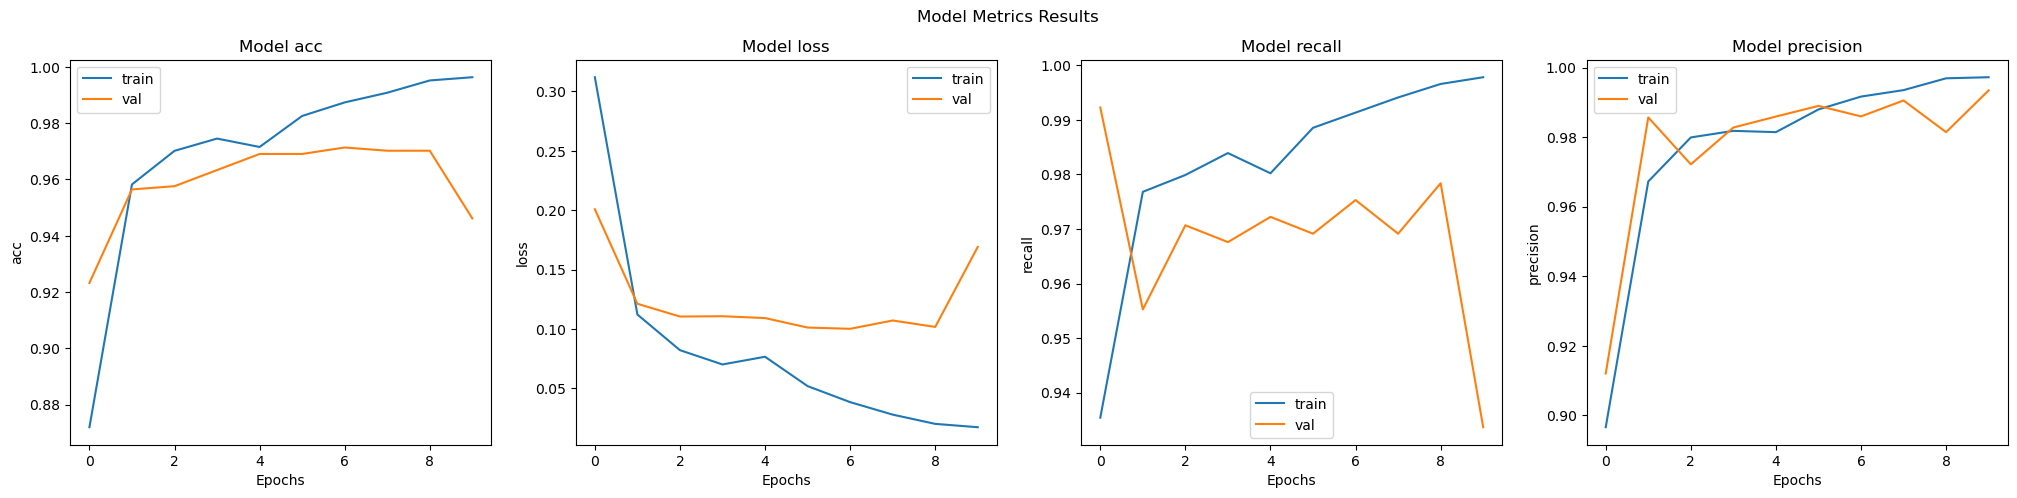

In [45]:
print("Basline Evaluation Metrics :\n")
eval_metrics(history)


Basline Evaluation Metrics w/ Class Weights :



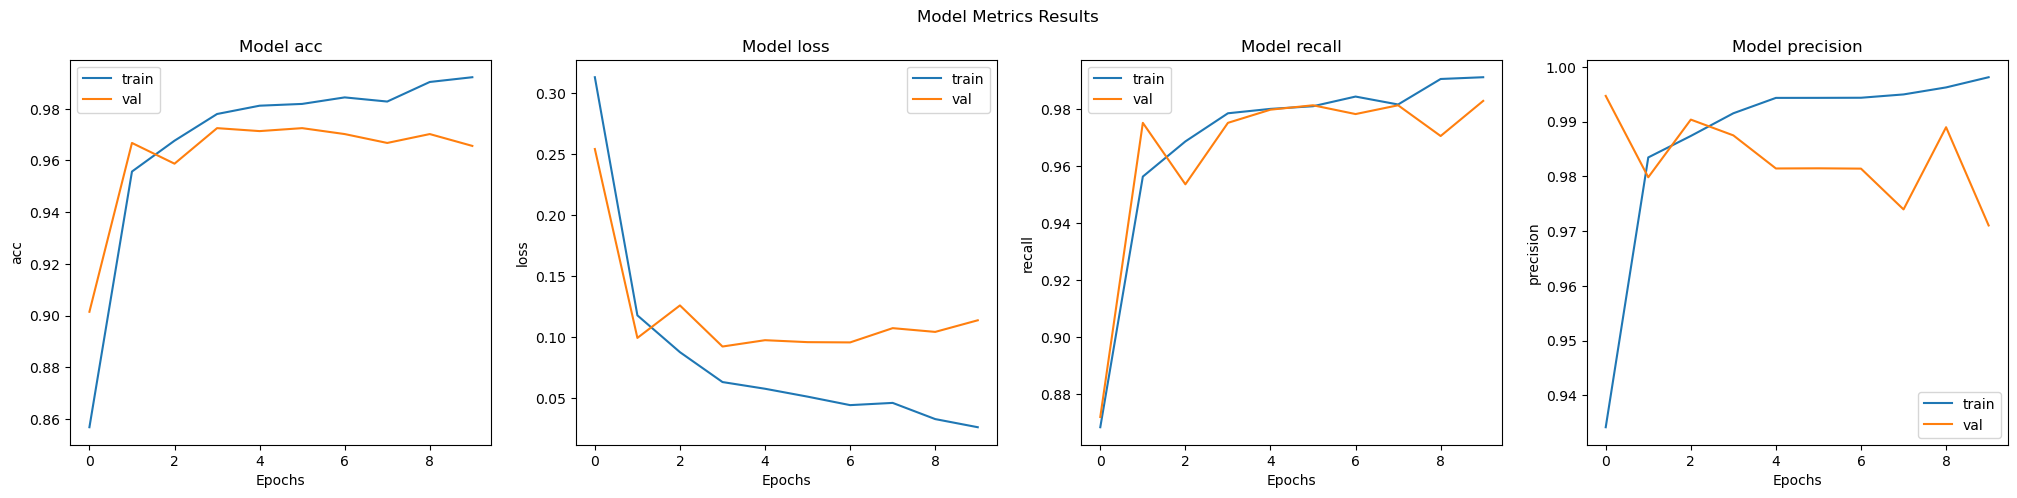

In [46]:
print("Basline Evaluation Metrics w/ Class Weights :\n")
eval_metrics(history2)

Drastic impovement with the class weight, but still includes high variation with recall and precision. The concludes that the model is still overfitting. Epoch 2 has the best Recall. The models start to diverage at Epoch 5.

In [47]:
train_labels, train_predictions = predict_results(baseline2,train_gen)
val_labels, val_predictions = predict_results(baseline2,val_gen)

2/2 [==============================] - 0s 27ms/step


2023-03-25 15:58:35.764808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


Training Confusion Matrices:



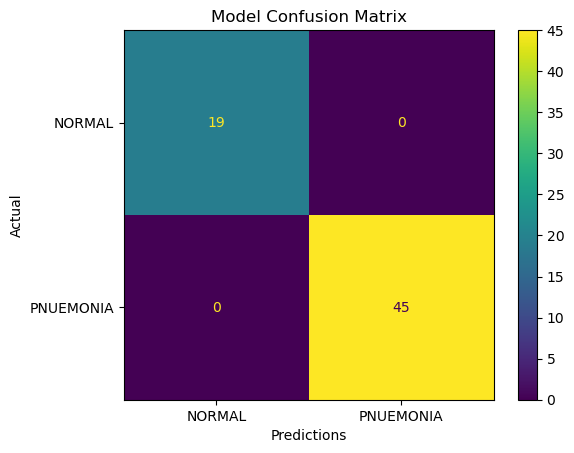

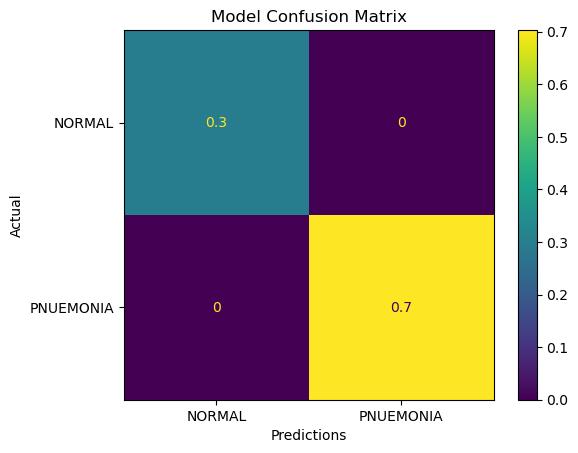

Validation Confusion Matrices:



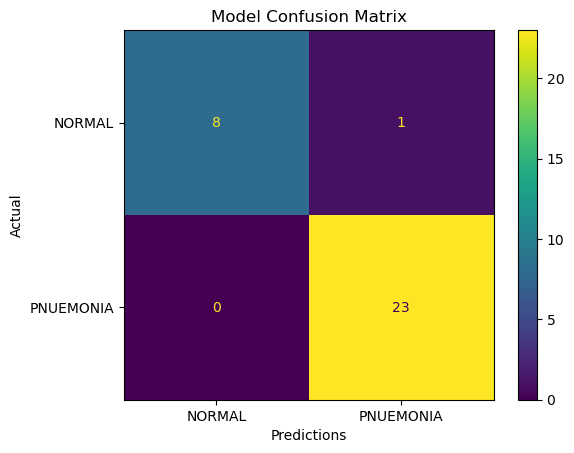

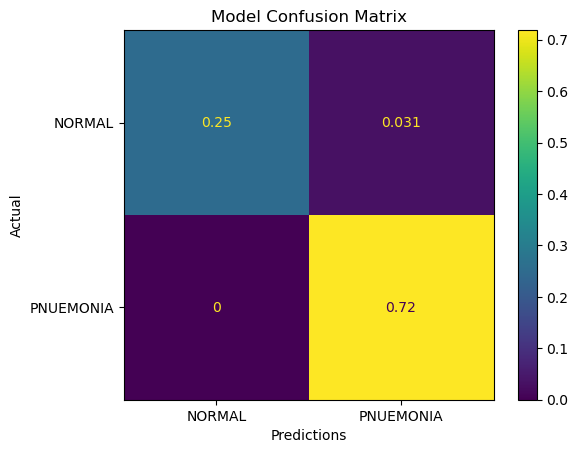

In [48]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [313]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history2)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        15
         1.0       1.00      0.98      0.99        49

    accuracy                           0.98        64
   macro avg       0.97      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64



69/69 [==============================] - 15s 222ms/step - loss: 0.0145 - acc: 0.9977 - recall: 0.9985 - precision: 0.9985
Loss: 0.01447878498584032
Loss: 0.9977059364318848
Loss: 0.9984544515609741


In [315]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history2)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95         9
         1.0       1.00      0.96      0.98        23

    accuracy                           0.97        32
   macro avg       0.95      0.98      0.96        32
weighted avg       0.97      0.97      0.97        32



28/28 [==============================] - 3s 108ms/step - loss: 0.1136 - acc: 0.9656 - recall: 0.9830 - precision: 0.9710
Loss: 0.11364420503377914


# Model Iteration 3

Describe the talk of hyperparameters to the Baseline version 2.
-Increasing Epochs to help with convergence
- Adding Earlystop at Epoch 5

- Dropout

In [51]:

model_3= models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='sigmoid'), 
Dropout(0.3),  
Dense(units=1, activation='sigmoid'),
])

In [52]:
model_3.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"]
                 )

In [53]:
#Adding early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [54]:
history3 = model_3.fit(train_gen,
                       epochs=30,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen,
                      callbacks = es)

Epoch 1/30


2023-03-25 15:58:56.173566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-25 15:59:12.290285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 - 20s - loss: 0.3436 - acc: 0.8429 - recall: 0.8594 - precision: 0.9236 - val_loss: 0.1507 - val_acc: 0.9485 - val_recall: 0.9460 - val_precision: 0.9839 - 20s/epoch - 288ms/step
Epoch 2/30
69/69 - 19s - loss: 0.1234 - acc: 0.9523 - recall: 0.9533 - precision: 0.9819 - val_loss: 0.1273 - val_acc: 0.9599 - val_recall: 0.9537 - val_precision: 0.9920 - 19s/epoch - 274ms/step
Epoch 3/30
69/69 - 19s - loss: 0.0961 - acc: 0.9647 - recall: 0.9651 - precision: 0.9870 - val_loss: 0.1165 - val_acc: 0.9668 - val_recall: 0.9630 - val_precision: 0.9921 - 19s/epoch - 279ms/step
Epoch 4/30
69/69 - 19s - loss: 0.1559 - acc: 0.9424 - recall: 0.9474 - precision: 0.9743 - val_loss: 0.1042 - val_acc: 0.9679 - val_recall: 0.9676 - val_precision: 0.9890 - 19s/epoch - 278ms/step
Epoch 5/30
69/69 - 19s - loss: 0.0776 - acc: 0.9720 - recall: 0.9719 - precision: 0.9902 - val_loss: 0.1018 - val_acc: 0.9668 - val_recall: 0.9707 - val_precision: 0.9844 - 19s/epoch - 276ms/step
Epoch 6/30
69/69 - 19s - loss: 

In [56]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 96)      

Basline Evaluation Metrics w/ Class Weights :



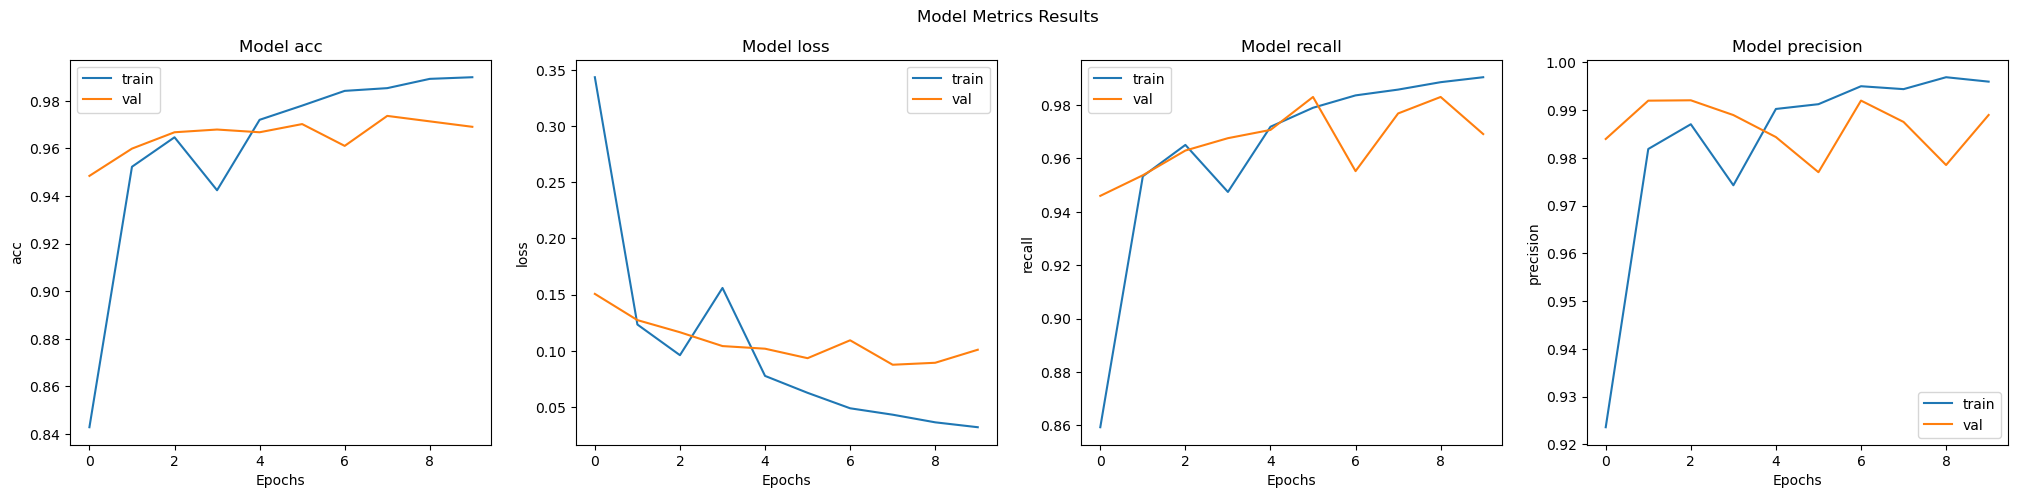

In [57]:
print("Basline Evaluation Metrics w/ Class Weights :\n")
eval_metrics(history3)

In [58]:
train_labels, train_predictions = predict_results(model_3,train_gen)
val_labels, val_predictions = predict_results(model_3,val_gen)

2/2 [==============================] - 0s 89ms/step


2023-03-25 16:02:39.248375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 16ms/step


Training Confusion Matrices:



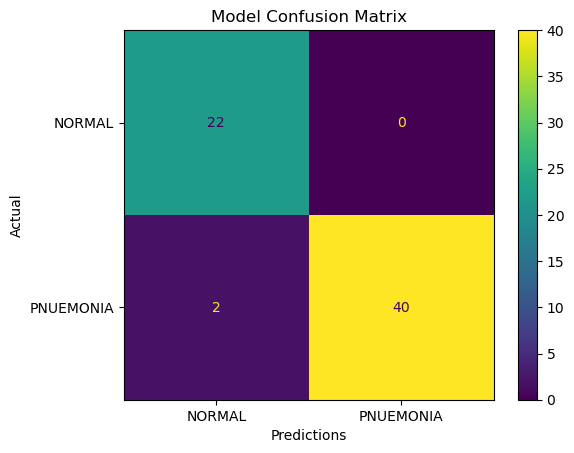

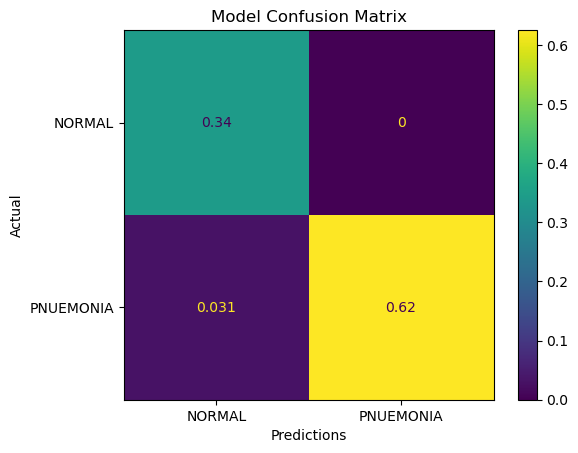

Validation Confusion Matrices:



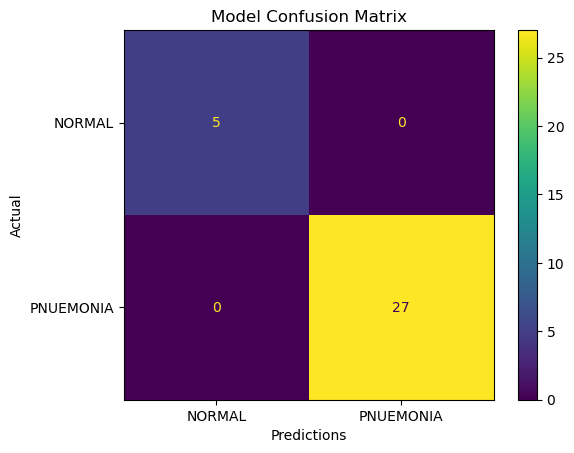

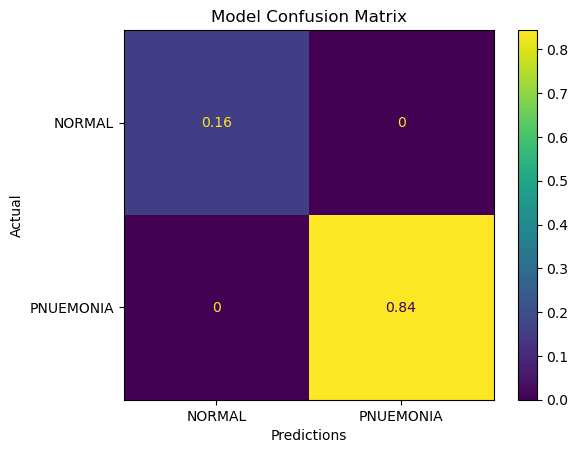

In [59]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [317]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history3)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        15
         1.0       1.00      0.98      0.99        49

    accuracy                           0.98        64
   macro avg       0.97      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64



69/69 [==============================] - 15s 218ms/step - loss: 0.0301 - acc: 0.9897 - recall: 0.9867 - precision: 0.9994
Loss: 0.030113618820905685


In [318]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history3)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95         9
         1.0       1.00      0.96      0.98        23

    accuracy                           0.97        32
   macro avg       0.95      0.98      0.96        32
weighted avg       0.97      0.97      0.97        32



28/28 [==============================] - 3s 111ms/step - loss: 0.1009 - acc: 0.9691 - recall: 0.9691 - precision: 0.9890
Loss: 0.10092896223068237


In [ ]:
#Data Augmentation, Add Layers, Change optimization learning rate,

# Model 4 - X

Using gridsearch and keras wrappers to do some hyperparameter optimization
- Optimizer
- Learning Rate and Momentum
- Batch Size and Epochs
- Neurons


In [64]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [112]:

def buildModel():

    model= models.Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2), 

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
        
    Flatten(),
    Dense(units=64, activation='sigmoid'), 
    Dropout(0.3),  
    Dense(units=1, activation='sigmoid'),])

    model.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=["acc","Recall","Precision"]
                 )
    return model

model_4.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=["acc","Recall","Precision"]
                 )

In [250]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [256]:
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)


{'batch_size': [1], 'epochs': [2]}

In [219]:
"""batch_size = [32,64,96,128]
epochs = [15,30,45]
optimizer = ['adam', 'rmsprop']
dropout = [.001,.01]
parameters = dict(batch_size=batch_size, epochs=epochs )
"""

In [228]:
classifier = KerasClassifier(build_fn=buildModel, class_weight = class_weights)
#What hyperparameter we want to play with

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           refit = "Acc",
                           scoring = "accuracy",
                           cv = 3,return_train_score=True)
gs = grid_search.fit(X_train, y_train, verbose = 0)

TypeError: cannot pickle '_thread.lock' object

In [223]:
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))

Best: 0.906205 using {'batch_size': 64, 'class_weight': {0: 1.5238095238095237, 1: 0.7441860465116279}, 'epochs': 45}


In [107]:
# Plot Model 4 with chosen parameters

In [255]:

model_4= models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

MaxPooling2D(pool_size=(2, 2), strides=2),
    
Dense(units=64, activation='sigmoid'),
Dropout(0.3),    
Dense(units=1, activation='sigmoid'),
])

In [230]:
model_4.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"]
                 )

In [251]:
history4 = model_4.fit(train_gen,batch_size=64,
                       epochs=45,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen,
                      callbacks = es) #stopping early because of time resources

Epoch 1/45
69/69 - 20s - loss: 0.0337 - acc: 0.9878 - recall: 0.9879 - precision: 0.9956 - val_loss: 0.0981 - val_acc: 0.9679 - val_recall: 0.9676 - val_precision: 0.9890 - 20s/epoch - 287ms/step
Epoch 2/45
69/69 - 20s - loss: 0.0243 - acc: 0.9933 - recall: 0.9926 - precision: 0.9984 - val_loss: 0.0942 - val_acc: 0.9702 - val_recall: 0.9738 - val_precision: 0.9859 - 20s/epoch - 285ms/step
Epoch 3/45
69/69 - 20s - loss: 0.0234 - acc: 0.9917 - recall: 0.9920 - precision: 0.9969 - val_loss: 0.0902 - val_acc: 0.9714 - val_recall: 0.9722 - val_precision: 0.9890 - 20s/epoch - 286ms/step
Epoch 4/45
69/69 - 20s - loss: 0.0165 - acc: 0.9954 - recall: 0.9954 - precision: 0.9984 - val_loss: 0.1009 - val_acc: 0.9679 - val_recall: 0.9753 - val_precision: 0.9814 - 20s/epoch - 285ms/step
Epoch 5/45
69/69 - 19s - loss: 0.0103 - acc: 0.9982 - recall: 0.9981 - precision: 0.9994 - val_loss: 0.0993 - val_acc: 0.9714 - val_recall: 0.9769 - val_precision: 0.9844 - 19s/epoch - 279ms/step
Epoch 6/45
69/69 - 2

In [ ]:
model_4.summary()

Basline Evaluation Metrics w/ Class Weights :



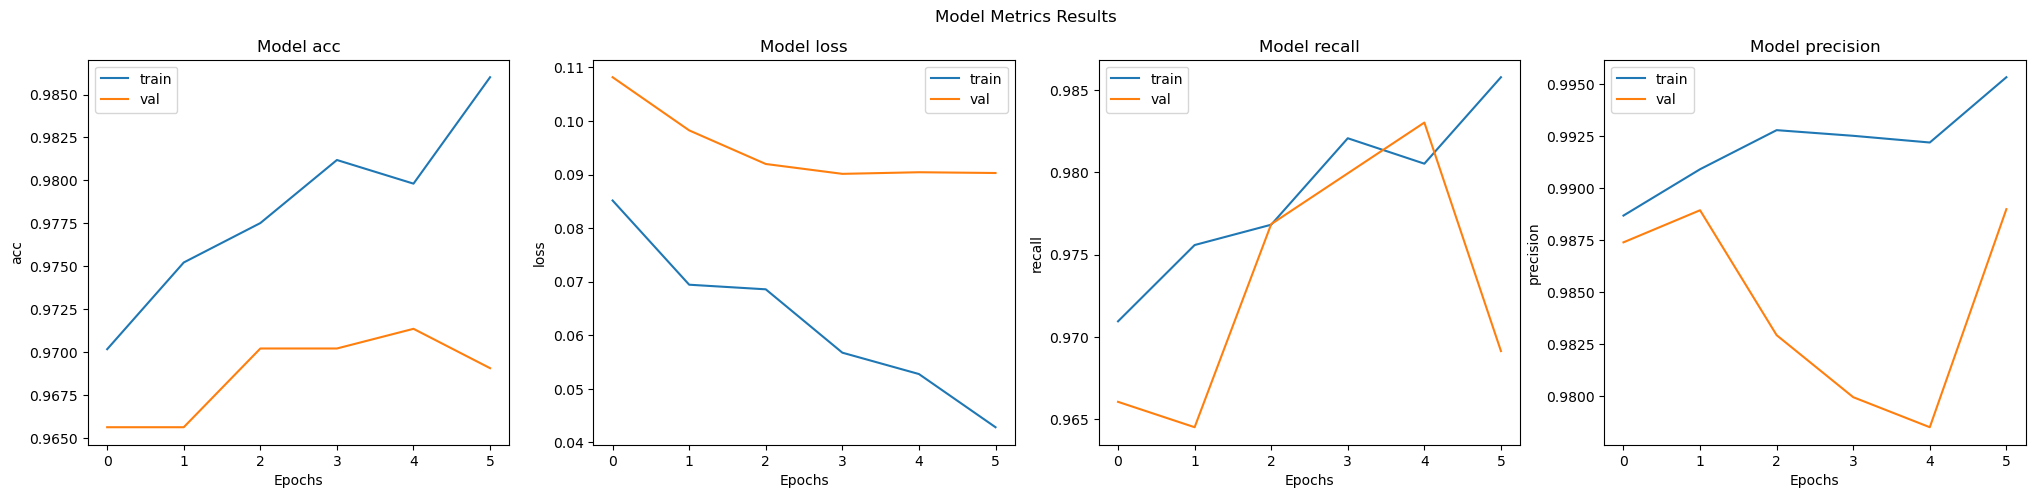

In [249]:
print("Basline Evaluation Metrics w/ Class Weights :\n")
eval_metrics(history4)

In [244]:
train_labels, train_predictions = predict_results(model_4,train_gen)
val_labels, val_predictions = predict_results(model_4,val_gen)

2/2 [==============================] - 0s 28ms/step


2023-03-25 19:07:10.092864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


Training Confusion Matrices:



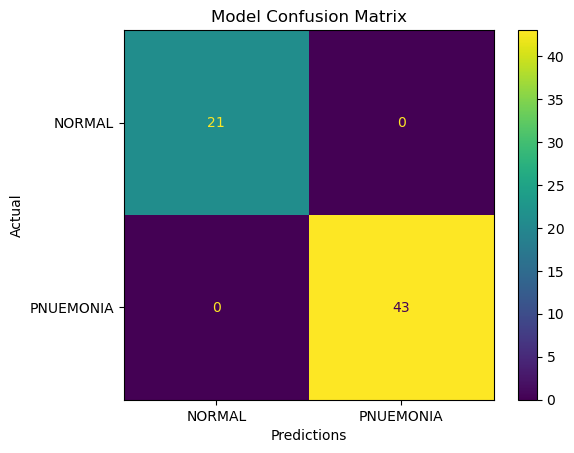

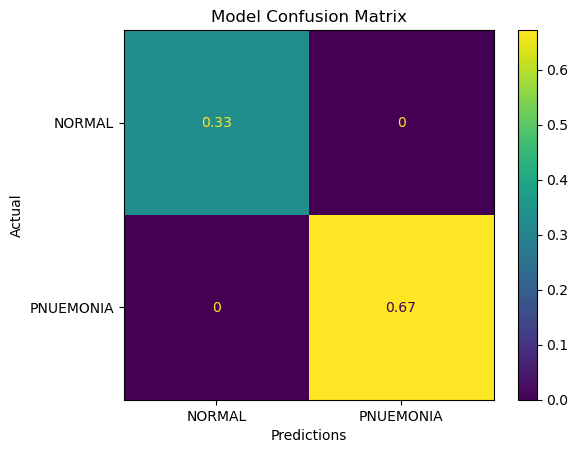

Validation Confusion Matrices:



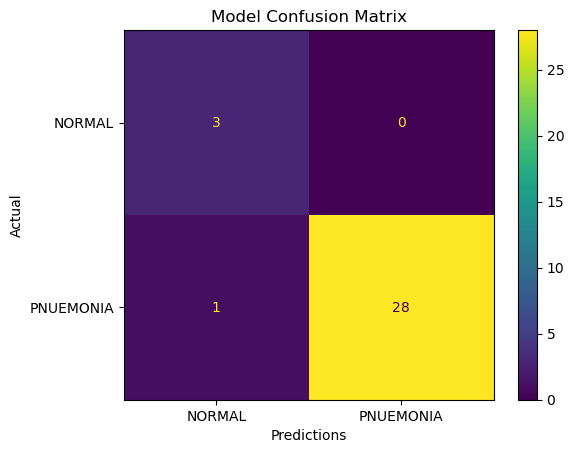

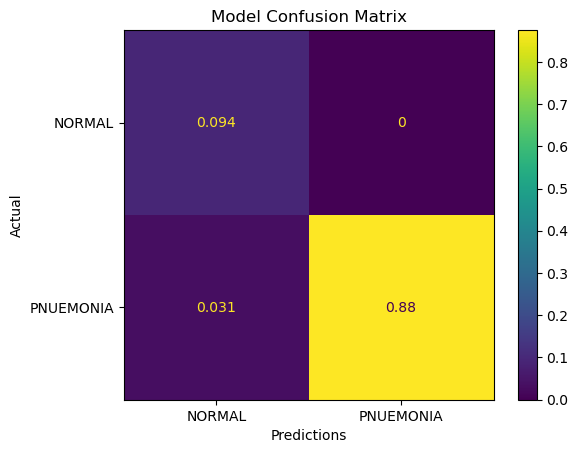

In [246]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [319]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history4)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        15
         1.0       1.00      0.98      0.99        49

    accuracy                           0.98        64
   macro avg       0.97      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64



69/69 [==============================] - 16s 226ms/step - loss: 0.0041 - acc: 0.9993 - recall: 0.9994 - precision: 0.9997
Loss: 0.004135084804147482


In [320]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history4)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95         9
         1.0       1.00      0.96      0.98        23

    accuracy                           0.97        32
   macro avg       0.95      0.98      0.96        32
weighted avg       0.97      0.97      0.97        32



28/28 [==============================] - 3s 118ms/step - loss: 0.1109 - acc: 0.9714 - recall: 0.9784 - precision: 0.9829
Loss: 0.1108979880809784


Accuracy and Loss metrics are improving. The visuals looks further apart but y-axis values are smaller. The small sample size for normal is limiting.

# Model 5

In [ ]:
Will add more layers for more complexity

In [287]:
def buildModel(dropout_rate, optimizer = "adam"):

    model= models.Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2), 

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),

    Dense(units=128, activation='relu',), 
    Dropout(dropout_rate),
    Dense(units=64, activation='relu'),
    Dropout(dropout_rate),    
    Dense(units=1, activation='sigmoid'),
    ])

    model.compile(loss='binary_crossentropy',
                    optimizer= optimizer,
                    metrics=["acc","Recall","Precision"]
                     )
    return model

In [291]:
#batch_size = [32,64,96,128,]
epochs = [45,75]
optimizer = ['adam', "SGD"]
dropout_rate = [.3,.5] 
parameters_2 = dict(optimizer=optimizer, dropout_rate=dropout_rate,  epochs=epochs )
parameters_2

{'optimizer': ['adam', 'SGD'], 'dropout_rate': [0.3, 0.5], 'epochs': [45, 75]}

In [292]:
classifier = KerasClassifier(build_fn=buildModel, batch_size = 96, class_weight = class_weights)
#What hyperparameter we want to play with

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters_2,
                           refit = "Acc",
                           scoring = "accuracy",
                           cv = 3,return_train_score=True)
gs_2 = grid_search.fit(X_train, y_train, verbose = 1)

Epoch 1/45


2023-03-25 20:53:04.181666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7185 - acc: 0.6667 - recall: 0.6538 - precision: 0.7727
Epoch 2/45
1/1 [==============================] - 0s 251ms/step - loss: 0.7134 - acc: 0.3571 - recall: 0.0769 - precision: 0.4000
Epoch 3/45
1/1 [==============================] - 0s 262ms/step - loss: 0.7346 - acc: 0.4048 - recall: 0.1923 - precision: 0.5556
Epoch 4/45
1/1 [==============================] - 0s 245ms/step - loss: 0.7095 - acc: 0.4286 - recall: 0.0769 - precision: 1.0000
Epoch 5/45
1/1 [==============================] - 0s 159ms/step - loss: 0.7243 - acc: 0.3810 - recall: 0.0385 - precision: 0.5000
Epoch 6/45
1/1 [==============================] - 0s 139ms/step - loss: 0.7152 - acc: 0.4048 - recall: 0.0385 - precision: 1.0000
Epoch 7/45
1/1 [==============================] - 0s 86ms/step - loss: 0.6953 - acc: 0.4048 - recall: 0.0385 - precision: 1.0000
Epoch 8/45
1/1 [==============================] - 0s 210ms/step - loss: 0.7120 - acc: 0.3571 - recall: 0.

2023-03-25 20:53:10.460642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 161ms/step
Epoch 1/45


2023-03-25 20:53:11.475550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6677 - acc: 0.6047 - recall: 0.7742 - precision: 0.7059
Epoch 2/45
1/1 [==============================] - 0s 308ms/step - loss: 0.6689 - acc: 0.6279 - recall: 0.8065 - precision: 0.7143
Epoch 3/45
1/1 [==============================] - 0s 243ms/step - loss: 0.6689 - acc: 0.5116 - recall: 0.5484 - precision: 0.7083
Epoch 4/45
1/1 [==============================] - 0s 195ms/step - loss: 0.6713 - acc: 0.6512 - recall: 0.8710 - precision: 0.7105
Epoch 5/45
1/1 [==============================] - 0s 239ms/step - loss: 0.6673 - acc: 0.7442 - recall: 0.9677 - precision: 0.7500
Epoch 6/45
1/1 [==============================] - 0s 252ms/step - loss: 0.6750 - acc: 0.6279 - recall: 0.8710 - precision: 0.6923
Epoch 7/45
1/1 [==============================] - 0s 127ms/step - loss: 0.6581 - acc: 0.7674 - recall: 0.9677 - precision: 0.7692
Epoch 8/45
1/1 [==============================] - 0s 136ms/step - loss: 0.6519 - acc: 0.7209 - recall: 0

2023-03-25 20:53:17.554447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 155ms/step
Epoch 1/45


2023-03-25 20:53:18.596102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6917 - acc: 0.5581 - recall: 0.5172 - precision: 0.7500
Epoch 2/45
1/1 [==============================] - 0s 255ms/step - loss: 0.7033 - acc: 0.4419 - recall: 0.5172 - precision: 0.6000
Epoch 3/45
1/1 [==============================] - 0s 114ms/step - loss: 0.6828 - acc: 0.5349 - recall: 0.4828 - precision: 0.7368
Epoch 4/45
1/1 [==============================] - 0s 238ms/step - loss: 0.6694 - acc: 0.5581 - recall: 0.4828 - precision: 0.7778
Epoch 5/45
1/1 [==============================] - 0s 163ms/step - loss: 0.7088 - acc: 0.4651 - recall: 0.4828 - precision: 0.6364
Epoch 6/45
1/1 [==============================] - 0s 229ms/step - loss: 0.7048 - acc: 0.4651 - recall: 0.3448 - precision: 0.7143
Epoch 7/45
1/1 [==============================] - 0s 231ms/step - loss: 0.7123 - acc: 0.4186 - recall: 0.2759 - precision: 0.6667
Epoch 8/45
1/1 [==============================] - 0s 132ms/step - loss: 0.7009 - acc: 0.3953 - recall: 0

2023-03-25 20:53:24.398887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 164ms/step
Epoch 1/45


2023-03-25 20:53:25.418405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.7239 - acc: 0.4524 - recall: 0.5769 - precision: 0.5556
Epoch 2/45
1/1 [==============================] - 0s 240ms/step - loss: 0.7238 - acc: 0.4524 - recall: 0.4615 - precision: 0.5714
Epoch 3/45
1/1 [==============================] - 0s 159ms/step - loss: 0.7200 - acc: 0.5714 - recall: 0.5000 - precision: 0.7222
Epoch 4/45
1/1 [==============================] - 0s 236ms/step - loss: 0.7223 - acc: 0.4286 - recall: 0.3846 - precision: 0.5556
Epoch 5/45
1/1 [==============================] - 0s 246ms/step - loss: 0.7195 - acc: 0.5000 - recall: 0.3462 - precision: 0.6923
Epoch 6/45
1/1 [==============================] - 0s 234ms/step - loss: 0.7170 - acc: 0.6667 - recall: 0.5385 - precision: 0.8750
Epoch 7/45
1/1 [==============================] - 0s 158ms/step - loss: 0.7228 - acc: 0.4048 - recall: 0.2692 - precision: 0.5385
Epoch 8/45
1/1 [==============================] - 0s 123ms/step - loss: 0.7217 - acc: 0.3810 - recall: 0

2023-03-25 20:53:30.994783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 197ms/step
Epoch 1/45


2023-03-25 20:53:32.010970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.6639 - acc: 0.5116 - recall: 0.5161 - precision: 0.7273
Epoch 2/45
1/1 [==============================] - 0s 226ms/step - loss: 0.6654 - acc: 0.4884 - recall: 0.5484 - precision: 0.6800
Epoch 3/45
1/1 [==============================] - 0s 228ms/step - loss: 0.6677 - acc: 0.4651 - recall: 0.5484 - precision: 0.6538
Epoch 4/45
1/1 [==============================] - 0s 242ms/step - loss: 0.6692 - acc: 0.5349 - recall: 0.6129 - precision: 0.7037
Epoch 5/45
1/1 [==============================] - 0s 77ms/step - loss: 0.6676 - acc: 0.6512 - recall: 0.7419 - precision: 0.7667
Epoch 6/45
1/1 [==============================] - 0s 212ms/step - loss: 0.6628 - acc: 0.6512 - recall: 0.7419 - precision: 0.7667
Epoch 7/45
1/1 [==============================] - 0s 154ms/step - loss: 0.6638 - acc: 0.6512 - recall: 0.7419 - precision: 0.7667
Epoch 8/45
1/1 [==============================] - 0s 55ms/step - loss: 0.6665 - acc: 0.6047 - recall: 0.7

2023-03-25 20:53:37.489930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 203ms/step
Epoch 1/45


2023-03-25 20:53:38.498354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6890 - acc: 0.6512 - recall: 0.6552 - precision: 0.7917
Epoch 2/45
1/1 [==============================] - 0s 395ms/step - loss: 0.6922 - acc: 0.4651 - recall: 0.5517 - precision: 0.6154
Epoch 3/45
1/1 [==============================] - 0s 248ms/step - loss: 0.6915 - acc: 0.5349 - recall: 0.5517 - precision: 0.6957
Epoch 4/45
1/1 [==============================] - 0s 248ms/step - loss: 0.6914 - acc: 0.5814 - recall: 0.6207 - precision: 0.7200
Epoch 5/45
1/1 [==============================] - 0s 173ms/step - loss: 0.6889 - acc: 0.5581 - recall: 0.5862 - precision: 0.7083
Epoch 6/45
1/1 [==============================] - 0s 79ms/step - loss: 0.6876 - acc: 0.6744 - recall: 0.6552 - precision: 0.8261
Epoch 7/45
1/1 [==============================] - 0s 229ms/step - loss: 0.6895 - acc: 0.5814 - recall: 0.6207 - precision: 0.7200
Epoch 8/45
1/1 [==============================] - 0s 235ms/step - loss: 0.6879 - acc: 0.6512 - recall: 0.

2023-03-25 20:53:44.250611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 210ms/step
Epoch 1/75


2023-03-25 20:53:45.863138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7237 - acc: 0.3810 - recall: 0.3846 - precision: 0.5000
Epoch 2/75
1/1 [==============================] - 0s 253ms/step - loss: 0.7144 - acc: 0.4048 - recall: 0.0769 - precision: 0.6667
Epoch 3/75
1/1 [==============================] - 0s 95ms/step - loss: 0.6999 - acc: 0.4286 - recall: 0.0769 - precision: 1.0000
Epoch 4/75
1/1 [==============================] - 0s 176ms/step - loss: 0.7208 - acc: 0.4524 - recall: 0.1154 - precision: 1.0000
Epoch 5/75
1/1 [==============================] - 0s 236ms/step - loss: 0.7109 - acc: 0.4048 - recall: 0.0769 - precision: 0.6667
Epoch 6/75
1/1 [==============================] - 0s 136ms/step - loss: 0.7071 - acc: 0.3571 - recall: 0.0385 - precision: 0.3333
Epoch 7/75
1/1 [==============================] - 0s 83ms/step - loss: 0.7017 - acc: 0.4524 - recall: 0.1154 - precision: 1.0000
Epoch 8/75
1/1 [==============================] - 0s 221ms/step - loss: 0.7191 - acc: 0.3571 - recall: 0.0

1/1 [==============================] - 0s 46ms/step - loss: 0.0030 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 65/75
1/1 [==============================] - 0s 48ms/step - loss: 0.0087 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 66/75
1/1 [==============================] - 0s 48ms/step - loss: 0.0012 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 67/75
1/1 [==============================] - 0s 47ms/step - loss: 5.1358e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 68/75
1/1 [==============================] - 0s 47ms/step - loss: 4.9105e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 69/75
1/1 [==============================] - 0s 48ms/step - loss: 7.2865e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 70/75
1/1 [==============================] - 0s 47ms/step - loss: 3.2029e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 71/75
1/1 [==============================] - 0s 48ms/step - loss: 0.0366 - acc: 

2023-03-25 20:53:53.210195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 220ms/step
Epoch 1/75


2023-03-25 20:53:54.277541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6643 - acc: 0.5814 - recall: 0.6452 - precision: 0.7407
Epoch 2/75
1/1 [==============================] - 0s 265ms/step - loss: 0.6718 - acc: 0.6977 - recall: 0.9677 - precision: 0.7143
Epoch 3/75
1/1 [==============================] - 0s 255ms/step - loss: 0.6585 - acc: 0.6512 - recall: 0.7419 - precision: 0.7667
Epoch 4/75
1/1 [==============================] - 0s 159ms/step - loss: 0.7025 - acc: 0.4884 - recall: 0.6774 - precision: 0.6364
Epoch 5/75
1/1 [==============================] - 0s 232ms/step - loss: 0.6668 - acc: 0.6279 - recall: 0.7419 - precision: 0.7419
Epoch 6/75
1/1 [==============================] - 0s 215ms/step - loss: 0.6609 - acc: 0.5581 - recall: 0.6774 - precision: 0.7000
Epoch 7/75
1/1 [==============================] - 0s 238ms/step - loss: 0.6690 - acc: 0.5116 - recall: 0.6129 - precision: 0.6786
Epoch 8/75
1/1 [==============================] - 0s 51ms/step - loss: 0.6625 - acc: 0.6512 - recall: 0.

1/1 [==============================] - 0s 49ms/step - loss: 0.0238 - acc: 0.9767 - recall: 0.9677 - precision: 1.0000
Epoch 64/75
1/1 [==============================] - 0s 48ms/step - loss: 0.1064 - acc: 0.9535 - recall: 1.0000 - precision: 0.9394
Epoch 65/75
1/1 [==============================] - 0s 48ms/step - loss: 1.7089e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 66/75
1/1 [==============================] - 0s 48ms/step - loss: 5.0630e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 67/75
1/1 [==============================] - 0s 49ms/step - loss: 0.0064 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 68/75
1/1 [==============================] - 0s 48ms/step - loss: 0.0690 - acc: 0.9535 - recall: 0.9355 - precision: 1.0000
Epoch 69/75
1/1 [==============================] - 0s 47ms/step - loss: 0.0186 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 70/75
1/1 [==============================] - 0s 48ms/step - loss: 0.0265 - acc: 1.0000 -

2023-03-25 20:54:01.762301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 156ms/step
Epoch 1/75


2023-03-25 20:54:02.762089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6901 - acc: 0.6047 - recall: 0.6552 - precision: 0.7308
Epoch 2/75
1/1 [==============================] - 0s 252ms/step - loss: 0.6946 - acc: 0.6047 - recall: 0.7586 - precision: 0.6875
Epoch 3/75
1/1 [==============================] - 0s 241ms/step - loss: 0.6841 - acc: 0.6047 - recall: 0.7241 - precision: 0.7000
Epoch 4/75
1/1 [==============================] - 0s 152ms/step - loss: 0.6523 - acc: 0.6744 - recall: 0.7241 - precision: 0.7778
Epoch 5/75
1/1 [==============================] - 0s 239ms/step - loss: 0.8394 - acc: 0.4186 - recall: 0.5172 - precision: 0.5769
Epoch 6/75
1/1 [==============================] - 0s 154ms/step - loss: 0.7039 - acc: 0.4419 - recall: 0.3448 - precision: 0.6667
Epoch 7/75
1/1 [==============================] - 0s 246ms/step - loss: 0.7123 - acc: 0.3256 - recall: 0.1724 - precision: 0.5000
Epoch 8/75
1/1 [==============================] - 0s 133ms/step - loss: 0.6964 - acc: 0.3488 - recall: 0

1/1 [==============================] - 0s 49ms/step - loss: 3.7262e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 64/75
1/1 [==============================] - 0s 48ms/step - loss: 0.2320 - acc: 0.9767 - recall: 1.0000 - precision: 0.9667
Epoch 65/75
1/1 [==============================] - 0s 49ms/step - loss: 0.0014 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 66/75
1/1 [==============================] - 0s 48ms/step - loss: 0.0841 - acc: 0.9767 - recall: 0.9655 - precision: 1.0000
Epoch 67/75
1/1 [==============================] - 0s 48ms/step - loss: 3.4268e-05 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 68/75
1/1 [==============================] - 0s 48ms/step - loss: 8.5324e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 69/75
1/1 [==============================] - 0s 48ms/step - loss: 9.7964e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 70/75
1/1 [==============================] - 0s 48ms/step - loss: 0.0029 - acc: 

2023-03-25 20:54:10.341444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 164ms/step
Epoch 1/75


2023-03-25 20:54:11.507560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7243 - acc: 0.4524 - recall: 0.6923 - precision: 0.5455
Epoch 2/75
1/1 [==============================] - 0s 247ms/step - loss: 0.7257 - acc: 0.4048 - recall: 0.4231 - precision: 0.5238
Epoch 3/75
1/1 [==============================] - 0s 241ms/step - loss: 0.7223 - acc: 0.4286 - recall: 0.3846 - precision: 0.5556
Epoch 4/75
1/1 [==============================] - 0s 216ms/step - loss: 0.7196 - acc: 0.4762 - recall: 0.3846 - precision: 0.6250
Epoch 5/75
1/1 [==============================] - 0s 243ms/step - loss: 0.7203 - acc: 0.4762 - recall: 0.3462 - precision: 0.6429
Epoch 6/75
1/1 [==============================] - 0s 159ms/step - loss: 0.7208 - acc: 0.4048 - recall: 0.2692 - precision: 0.5385
Epoch 7/75
1/1 [==============================] - 0s 242ms/step - loss: 0.7194 - acc: 0.3810 - recall: 0.1538 - precision: 0.5000
Epoch 8/75
1/1 [==============================] - 0s 227ms/step - loss: 0.7176 - acc: 0.4524 - recall: 0

1/1 [==============================] - 0s 47ms/step - loss: 0.7106 - acc: 0.3571 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 64/75
1/1 [==============================] - 0s 47ms/step - loss: 0.7078 - acc: 0.3571 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 65/75
1/1 [==============================] - 0s 47ms/step - loss: 0.7101 - acc: 0.4048 - recall: 0.0385 - precision: 1.0000
Epoch 66/75
1/1 [==============================] - 0s 47ms/step - loss: 0.7094 - acc: 0.4048 - recall: 0.0385 - precision: 1.0000
Epoch 67/75
1/1 [==============================] - 0s 46ms/step - loss: 0.7022 - acc: 0.4286 - recall: 0.0769 - precision: 1.0000
Epoch 68/75
1/1 [==============================] - 0s 46ms/step - loss: 0.7119 - acc: 0.3571 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 69/75
1/1 [==============================] - 0s 46ms/step - loss: 0.7148 - acc: 0.3810 - recall: 0.0385 - precision: 0.5000
Epoch 70/75
1/1 [==============================] - 0s 47ms/step - loss: 0.7126

2023-03-25 20:54:18.632831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 161ms/step
Epoch 1/75


2023-03-25 20:54:19.676295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6647 - acc: 0.5349 - recall: 0.5484 - precision: 0.7391
Epoch 2/75
1/1 [==============================] - 0s 243ms/step - loss: 0.6678 - acc: 0.5349 - recall: 0.5806 - precision: 0.7200
Epoch 3/75
1/1 [==============================] - 0s 155ms/step - loss: 0.6689 - acc: 0.5814 - recall: 0.6129 - precision: 0.7600
Epoch 4/75
1/1 [==============================] - 0s 162ms/step - loss: 0.6669 - acc: 0.6512 - recall: 0.7419 - precision: 0.7667
Epoch 5/75
1/1 [==============================] - 0s 242ms/step - loss: 0.6618 - acc: 0.6977 - recall: 0.8065 - precision: 0.7812
Epoch 6/75
1/1 [==============================] - 0s 85ms/step - loss: 0.6661 - acc: 0.6512 - recall: 0.8387 - precision: 0.7222
Epoch 7/75
1/1 [==============================] - 0s 168ms/step - loss: 0.6684 - acc: 0.7209 - recall: 0.9032 - precision: 0.7568
Epoch 8/75
1/1 [==============================] - 0s 145ms/step - loss: 0.6668 - acc: 0.6512 - recall: 0.

1/1 [==============================] - 0s 47ms/step - loss: 0.6597 - acc: 0.7209 - recall: 1.0000 - precision: 0.7209
Epoch 65/75
1/1 [==============================] - 0s 46ms/step - loss: 0.6563 - acc: 0.7209 - recall: 1.0000 - precision: 0.7209
Epoch 66/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6537 - acc: 0.7209 - recall: 1.0000 - precision: 0.7209
Epoch 67/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6563 - acc: 0.7209 - recall: 1.0000 - precision: 0.7209
Epoch 68/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6525 - acc: 0.7209 - recall: 1.0000 - precision: 0.7209
Epoch 69/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6507 - acc: 0.7209 - recall: 1.0000 - precision: 0.7209
Epoch 70/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6541 - acc: 0.7209 - recall: 1.0000 - precision: 0.7209
Epoch 71/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6558 - acc: 0.7209 - recall:

2023-03-25 20:54:26.988068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 168ms/step
Epoch 1/75


2023-03-25 20:54:28.629111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6941 - acc: 0.3953 - recall: 0.5517 - precision: 0.5517
Epoch 2/75
1/1 [==============================] - 0s 243ms/step - loss: 0.6899 - acc: 0.5116 - recall: 0.4828 - precision: 0.7000
Epoch 3/75
1/1 [==============================] - 0s 249ms/step - loss: 0.6911 - acc: 0.5116 - recall: 0.5172 - precision: 0.6818
Epoch 4/75
1/1 [==============================] - 0s 99ms/step - loss: 0.6934 - acc: 0.4419 - recall: 0.5172 - precision: 0.6000
Epoch 5/75
1/1 [==============================] - 0s 152ms/step - loss: 0.6904 - acc: 0.5349 - recall: 0.4828 - precision: 0.7368
Epoch 6/75
1/1 [==============================] - 0s 166ms/step - loss: 0.6904 - acc: 0.4884 - recall: 0.4828 - precision: 0.6667
Epoch 7/75
1/1 [==============================] - 0s 164ms/step - loss: 0.6923 - acc: 0.5581 - recall: 0.5517 - precision: 0.7273
Epoch 8/75
1/1 [==============================] - 0s 395ms/step - loss: 0.6886 - acc: 0.6512 - recall: 0.

1/1 [==============================] - 0s 47ms/step - loss: 0.6855 - acc: 0.6279 - recall: 0.5862 - precision: 0.8095
Epoch 65/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6847 - acc: 0.6512 - recall: 0.5862 - precision: 0.8500
Epoch 66/75
1/1 [==============================] - 0s 48ms/step - loss: 0.6864 - acc: 0.5814 - recall: 0.6207 - precision: 0.7200
Epoch 67/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6886 - acc: 0.5116 - recall: 0.4138 - precision: 0.7500
Epoch 68/75
1/1 [==============================] - 0s 48ms/step - loss: 0.6880 - acc: 0.6047 - recall: 0.6207 - precision: 0.7500
Epoch 69/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6868 - acc: 0.6744 - recall: 0.6552 - precision: 0.8261
Epoch 70/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6861 - acc: 0.5581 - recall: 0.4828 - precision: 0.7778
Epoch 71/75
1/1 [==============================] - 0s 48ms/step - loss: 0.6813 - acc: 0.6744 - recall:

2023-03-25 20:54:36.007933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 164ms/step
Epoch 1/45


2023-03-25 20:54:37.078356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7205 - acc: 0.5476 - recall: 0.5769 - precision: 0.6522
Epoch 2/45
1/1 [==============================] - 0s 184ms/step - loss: 0.7145 - acc: 0.5476 - recall: 0.5385 - precision: 0.6667
Epoch 3/45
1/1 [==============================] - 0s 60ms/step - loss: 0.7455 - acc: 0.4524 - recall: 0.4231 - precision: 0.5789
Epoch 4/45
1/1 [==============================] - 0s 250ms/step - loss: 0.7519 - acc: 0.5238 - recall: 0.4615 - precision: 0.6667
Epoch 5/45
1/1 [==============================] - 0s 156ms/step - loss: 0.7304 - acc: 0.4286 - recall: 0.2692 - precision: 0.5833
Epoch 6/45
1/1 [==============================] - 0s 247ms/step - loss: 0.6983 - acc: 0.5476 - recall: 0.3077 - precision: 0.8889
Epoch 7/45
1/1 [==============================] - 0s 217ms/step - loss: 0.7149 - acc: 0.4048 - recall: 0.1154 - precision: 0.6000
Epoch 8/45
1/1 [==============================] - 0s 227ms/step - loss: 0.7127 - acc: 0.4048 - recall: 0.

2023-03-25 20:54:42.887608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 208ms/step
Epoch 1/45


2023-03-25 20:54:43.990599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6685 - acc: 0.5116 - recall: 0.5484 - precision: 0.7083
Epoch 2/45
1/1 [==============================] - 0s 334ms/step - loss: 0.6675 - acc: 0.5581 - recall: 0.7097 - precision: 0.6875
Epoch 3/45
1/1 [==============================] - 0s 246ms/step - loss: 0.6837 - acc: 0.6047 - recall: 0.7419 - precision: 0.7188
Epoch 4/45
1/1 [==============================] - 0s 174ms/step - loss: 0.6698 - acc: 0.6047 - recall: 0.7742 - precision: 0.7059
Epoch 5/45
1/1 [==============================] - 0s 233ms/step - loss: 0.6676 - acc: 0.6512 - recall: 0.8065 - precision: 0.7353
Epoch 6/45
1/1 [==============================] - 0s 171ms/step - loss: 0.6691 - acc: 0.6512 - recall: 0.9032 - precision: 0.7000
Epoch 7/45
1/1 [==============================] - 0s 213ms/step - loss: 0.6690 - acc: 0.6977 - recall: 0.9355 - precision: 0.7250
Epoch 8/45
1/1 [==============================] - 0s 161ms/step - loss: 0.6576 - acc: 0.7442 - recall: 0

2023-03-25 20:54:49.867967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 158ms/step
Epoch 1/45


2023-03-25 20:54:50.875513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6932 - acc: 0.4884 - recall: 0.5517 - precision: 0.6400
Epoch 2/45
1/1 [==============================] - 0s 255ms/step - loss: 0.6921 - acc: 0.5814 - recall: 0.5517 - precision: 0.7619
Epoch 3/45
1/1 [==============================] - 0s 247ms/step - loss: 0.6936 - acc: 0.4651 - recall: 0.4828 - precision: 0.6364
Epoch 4/45
1/1 [==============================] - 0s 250ms/step - loss: 0.6889 - acc: 0.5116 - recall: 0.5172 - precision: 0.6818
Epoch 5/45
1/1 [==============================] - 0s 252ms/step - loss: 0.7335 - acc: 0.4884 - recall: 0.5862 - precision: 0.6296
Epoch 6/45
1/1 [==============================] - 0s 166ms/step - loss: 0.6987 - acc: 0.6279 - recall: 0.7241 - precision: 0.7241
Epoch 7/45
1/1 [==============================] - 0s 155ms/step - loss: 0.7082 - acc: 0.4186 - recall: 0.4483 - precision: 0.5909
Epoch 8/45
1/1 [==============================] - 0s 51ms/step - loss: 0.6847 - acc: 0.5814 - recall: 0.

2023-03-25 20:54:56.596513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 208ms/step
Epoch 1/45


2023-03-25 20:54:57.625901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7234 - acc: 0.4048 - recall: 0.4615 - precision: 0.5217
Epoch 2/45
1/1 [==============================] - 0s 253ms/step - loss: 0.7295 - acc: 0.3810 - recall: 0.3462 - precision: 0.5000
Epoch 3/45
1/1 [==============================] - 0s 232ms/step - loss: 0.7265 - acc: 0.4524 - recall: 0.4231 - precision: 0.5789
Epoch 4/45
1/1 [==============================] - 0s 186ms/step - loss: 0.7245 - acc: 0.3810 - recall: 0.3462 - precision: 0.5000
Epoch 5/45
1/1 [==============================] - 0s 246ms/step - loss: 0.7248 - acc: 0.4524 - recall: 0.3846 - precision: 0.5882
Epoch 6/45
1/1 [==============================] - 0s 160ms/step - loss: 0.7269 - acc: 0.4524 - recall: 0.3846 - precision: 0.5882
Epoch 7/45
1/1 [==============================] - 0s 53ms/step - loss: 0.7216 - acc: 0.4762 - recall: 0.4231 - precision: 0.6111
Epoch 8/45
1/1 [==============================] - 0s 216ms/step - loss: 0.7288 - acc: 0.2619 - recall: 0.

2023-03-25 20:55:03.450403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 200ms/step
Epoch 1/45


2023-03-25 20:55:05.186107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6634 - acc: 0.6047 - recall: 0.5161 - precision: 0.8889
Epoch 2/45
1/1 [==============================] - 0s 241ms/step - loss: 0.6537 - acc: 0.7907 - recall: 0.7419 - precision: 0.9583
Epoch 3/45
1/1 [==============================] - 0s 157ms/step - loss: 0.6657 - acc: 0.5349 - recall: 0.5484 - precision: 0.7391
Epoch 4/45
1/1 [==============================] - 0s 216ms/step - loss: 0.6624 - acc: 0.6047 - recall: 0.6774 - precision: 0.7500
Epoch 5/45
1/1 [==============================] - 0s 163ms/step - loss: 0.6627 - acc: 0.5814 - recall: 0.6452 - precision: 0.7407
Epoch 6/45
1/1 [==============================] - 0s 168ms/step - loss: 0.6672 - acc: 0.5349 - recall: 0.6129 - precision: 0.7037
Epoch 7/45
1/1 [==============================] - 0s 159ms/step - loss: 0.6615 - acc: 0.6279 - recall: 0.6774 - precision: 0.7778
Epoch 8/45
1/1 [==============================] - 0s 240ms/step - loss: 0.6611 - acc: 0.6047 - recall: 0

2023-03-25 20:55:10.728304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 166ms/step
Epoch 1/45


2023-03-25 20:55:12.431593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 0.6923 - acc: 0.5814 - recall: 0.7241 - precision: 0.6774
Epoch 2/45
1/1 [==============================] - 0s 247ms/step - loss: 0.6966 - acc: 0.4651 - recall: 0.5172 - precision: 0.6250
Epoch 3/45
1/1 [==============================] - 0s 246ms/step - loss: 0.6914 - acc: 0.4884 - recall: 0.4828 - precision: 0.6667
Epoch 4/45
1/1 [==============================] - 0s 162ms/step - loss: 0.6868 - acc: 0.6047 - recall: 0.5862 - precision: 0.7727
Epoch 5/45
1/1 [==============================] - 0s 164ms/step - loss: 0.6939 - acc: 0.5349 - recall: 0.5862 - precision: 0.6800
Epoch 6/45
1/1 [==============================] - 0s 448ms/step - loss: 0.6894 - acc: 0.5814 - recall: 0.5862 - precision: 0.7391
Epoch 7/45
1/1 [==============================] - 0s 234ms/step - loss: 0.6895 - acc: 0.5814 - recall: 0.5862 - precision: 0.7391
Epoch 8/45
1/1 [==============================] - 0s 53ms/step - loss: 0.6909 - acc: 0.6047 - recall: 0.

2023-03-25 20:55:18.755342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 159ms/step
Epoch 1/75


2023-03-25 20:55:19.843506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7248 - acc: 0.5238 - recall: 0.5769 - precision: 0.6250
Epoch 2/75
1/1 [==============================] - 0s 257ms/step - loss: 0.7281 - acc: 0.3571 - recall: 0.2308 - precision: 0.4615
Epoch 3/75
1/1 [==============================] - 0s 181ms/step - loss: 0.6805 - acc: 0.4762 - recall: 0.1538 - precision: 1.0000
Epoch 4/75
1/1 [==============================] - 0s 164ms/step - loss: 0.7072 - acc: 0.3571 - recall: 0.1154 - precision: 0.4286
Epoch 5/75
1/1 [==============================] - 0s 259ms/step - loss: 0.7272 - acc: 0.4524 - recall: 0.1538 - precision: 0.8000
Epoch 6/75
1/1 [==============================] - 0s 54ms/step - loss: 0.7624 - acc: 0.3571 - recall: 0.1154 - precision: 0.4286
Epoch 7/75
1/1 [==============================] - 0s 328ms/step - loss: 0.7110 - acc: 0.4524 - recall: 0.2692 - precision: 0.6364
Epoch 8/75
1/1 [==============================] - 0s 173ms/step - loss: 0.7157 - acc: 0.4762 - recall: 0.

1/1 [==============================] - 0s 47ms/step - loss: 0.0013 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 65/75
1/1 [==============================] - 0s 46ms/step - loss: 0.0013 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 66/75
1/1 [==============================] - 0s 46ms/step - loss: 0.0333 - acc: 0.9762 - recall: 1.0000 - precision: 0.9630
Epoch 67/75
1/1 [==============================] - 0s 47ms/step - loss: 0.0304 - acc: 0.9762 - recall: 1.0000 - precision: 0.9630
Epoch 68/75
1/1 [==============================] - 0s 47ms/step - loss: 0.0090 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 69/75
1/1 [==============================] - 0s 47ms/step - loss: 0.0315 - acc: 0.9762 - recall: 1.0000 - precision: 0.9630
Epoch 70/75
1/1 [==============================] - 0s 47ms/step - loss: 0.0253 - acc: 0.9762 - recall: 1.0000 - precision: 0.9630
Epoch 71/75
1/1 [==============================] - 0s 46ms/step - loss: 0.0254 - acc: 0.9762 - recall:

2023-03-25 20:55:27.377868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 162ms/step
Epoch 1/75


2023-03-25 20:55:28.439095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6629 - acc: 0.6047 - recall: 0.5806 - precision: 0.8182
Epoch 2/75
1/1 [==============================] - 0s 260ms/step - loss: 0.6982 - acc: 0.5814 - recall: 0.7419 - precision: 0.6970
Epoch 3/75
1/1 [==============================] - 0s 245ms/step - loss: 0.6518 - acc: 0.6047 - recall: 0.6774 - precision: 0.7500
Epoch 4/75
1/1 [==============================] - 0s 183ms/step - loss: 0.6613 - acc: 0.6279 - recall: 0.7419 - precision: 0.7419
Epoch 5/75
1/1 [==============================] - 0s 272ms/step - loss: 0.6819 - acc: 0.5581 - recall: 0.5806 - precision: 0.7500
Epoch 6/75
1/1 [==============================] - 0s 130ms/step - loss: 0.6706 - acc: 0.5116 - recall: 0.5161 - precision: 0.7273
Epoch 7/75
1/1 [==============================] - 0s 136ms/step - loss: 0.6650 - acc: 0.4884 - recall: 0.5161 - precision: 0.6957
Epoch 8/75
1/1 [==============================] - 0s 142ms/step - loss: 0.6842 - acc: 0.4419 - recall: 0

1/1 [==============================] - 0s 49ms/step - loss: 0.0010 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 65/75
1/1 [==============================] - 0s 49ms/step - loss: 8.6497e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 66/75
1/1 [==============================] - 0s 49ms/step - loss: 0.0075 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 67/75
1/1 [==============================] - 0s 50ms/step - loss: 0.1432 - acc: 0.9767 - recall: 1.0000 - precision: 0.9688
Epoch 68/75
1/1 [==============================] - 0s 50ms/step - loss: 0.0271 - acc: 0.9767 - recall: 1.0000 - precision: 0.9688
Epoch 69/75
1/1 [==============================] - 0s 48ms/step - loss: 6.0568e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 70/75
1/1 [==============================] - 0s 48ms/step - loss: 0.0010 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 71/75
1/1 [==============================] - 0s 49ms/step - loss: 0.0113 - acc: 1.0000 -

2023-03-25 20:55:36.275028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 208ms/step
Epoch 1/75


2023-03-25 20:55:37.374209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6880 - acc: 0.5349 - recall: 0.5172 - precision: 0.7143
Epoch 2/75
1/1 [==============================] - 0s 98ms/step - loss: 0.7039 - acc: 0.5814 - recall: 0.7586 - precision: 0.6667
Epoch 3/75
1/1 [==============================] - 0s 174ms/step - loss: 0.7139 - acc: 0.6047 - recall: 0.6897 - precision: 0.7143
Epoch 4/75
1/1 [==============================] - 0s 235ms/step - loss: 0.6750 - acc: 0.5814 - recall: 0.6552 - precision: 0.7037
Epoch 5/75
1/1 [==============================] - 0s 253ms/step - loss: 0.7089 - acc: 0.4186 - recall: 0.4828 - precision: 0.5833
Epoch 6/75
1/1 [==============================] - 0s 129ms/step - loss: 0.6835 - acc: 0.5581 - recall: 0.5172 - precision: 0.7500
Epoch 7/75
1/1 [==============================] - 0s 88ms/step - loss: 0.6716 - acc: 0.5814 - recall: 0.5517 - precision: 0.7619
Epoch 8/75
1/1 [==============================] - 0s 137ms/step - loss: 0.6998 - acc: 0.5349 - recall: 0.5

1/1 [==============================] - 0s 48ms/step - loss: 0.0257 - acc: 0.9767 - recall: 0.9655 - precision: 1.0000
Epoch 65/75
1/1 [==============================] - 0s 49ms/step - loss: 0.0331 - acc: 0.9767 - recall: 1.0000 - precision: 0.9667
Epoch 66/75
1/1 [==============================] - 0s 63ms/step - loss: 0.0028 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 67/75
1/1 [==============================] - 0s 48ms/step - loss: 0.0547 - acc: 0.9767 - recall: 1.0000 - precision: 0.9667
Epoch 68/75
1/1 [==============================] - 0s 48ms/step - loss: 0.0015 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 69/75
1/1 [==============================] - 0s 48ms/step - loss: 9.0552e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 70/75
1/1 [==============================] - 0s 47ms/step - loss: 6.4774e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 71/75
1/1 [==============================] - 0s 48ms/step - loss: 0.0070 - acc: 1.0000 -

2023-03-25 20:55:44.979952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 213ms/step
Epoch 1/75


2023-03-25 20:55:46.025154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7197 - acc: 0.5238 - recall: 0.5385 - precision: 0.6364
Epoch 2/75
1/1 [==============================] - 0s 229ms/step - loss: 0.7227 - acc: 0.4762 - recall: 0.4615 - precision: 0.6000
Epoch 3/75
1/1 [==============================] - 0s 163ms/step - loss: 0.7269 - acc: 0.3571 - recall: 0.3462 - precision: 0.4737
Epoch 4/75
1/1 [==============================] - 0s 161ms/step - loss: 0.7215 - acc: 0.5714 - recall: 0.5000 - precision: 0.7222
Epoch 5/75
1/1 [==============================] - 0s 182ms/step - loss: 0.7220 - acc: 0.4286 - recall: 0.3846 - precision: 0.5556
Epoch 6/75
1/1 [==============================] - 0s 159ms/step - loss: 0.7195 - acc: 0.5238 - recall: 0.4615 - precision: 0.6667
Epoch 7/75
1/1 [==============================] - 0s 246ms/step - loss: 0.7171 - acc: 0.5476 - recall: 0.4615 - precision: 0.7059
Epoch 8/75
1/1 [==============================] - 0s 133ms/step - loss: 0.7251 - acc: 0.3095 - recall: 0

1/1 [==============================] - 0s 47ms/step - loss: 0.7254 - acc: 0.3333 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 64/75
1/1 [==============================] - 0s 47ms/step - loss: 0.7084 - acc: 0.4286 - recall: 0.0769 - precision: 1.0000
Epoch 65/75
1/1 [==============================] - 0s 46ms/step - loss: 0.7118 - acc: 0.4524 - recall: 0.1154 - precision: 1.0000
Epoch 66/75
1/1 [==============================] - 0s 46ms/step - loss: 0.7220 - acc: 0.3810 - recall: 0.0385 - precision: 0.5000
Epoch 67/75
1/1 [==============================] - 0s 46ms/step - loss: 0.7066 - acc: 0.4286 - recall: 0.0769 - precision: 1.0000
Epoch 68/75
1/1 [==============================] - 0s 47ms/step - loss: 0.7154 - acc: 0.4524 - recall: 0.1154 - precision: 1.0000
Epoch 69/75
1/1 [==============================] - 0s 109ms/step - loss: 0.7116 - acc: 0.4048 - recall: 0.0769 - precision: 0.6667
Epoch 70/75
1/1 [==============================] - 0s 130ms/step - loss: 0.7105 - acc: 0.3810

2023-03-25 20:55:53.406684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 164ms/step
Epoch 1/75


2023-03-25 20:55:54.975869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6695 - acc: 0.3953 - recall: 0.3548 - precision: 0.6471
Epoch 2/75
1/1 [==============================] - 0s 177ms/step - loss: 0.6637 - acc: 0.5581 - recall: 0.6129 - precision: 0.7308
Epoch 3/75
1/1 [==============================] - 0s 223ms/step - loss: 0.6679 - acc: 0.5349 - recall: 0.5484 - precision: 0.7391
Epoch 4/75
1/1 [==============================] - 0s 241ms/step - loss: 0.6607 - acc: 0.6512 - recall: 0.6774 - precision: 0.8077
Epoch 5/75
1/1 [==============================] - 0s 228ms/step - loss: 0.6588 - acc: 0.6977 - recall: 0.7742 - precision: 0.8000
Epoch 6/75
1/1 [==============================] - 0s 162ms/step - loss: 0.6636 - acc: 0.5349 - recall: 0.6452 - precision: 0.6897
Epoch 7/75
1/1 [==============================] - 0s 238ms/step - loss: 0.6563 - acc: 0.7442 - recall: 0.8065 - precision: 0.8333
Epoch 8/75
1/1 [==============================] - 0s 229ms/step - loss: 0.6626 - acc: 0.6512 - recall: 0

1/1 [==============================] - 0s 48ms/step - loss: 0.6535 - acc: 0.6977 - recall: 0.9677 - precision: 0.7143
Epoch 65/75
1/1 [==============================] - 0s 51ms/step - loss: 0.6609 - acc: 0.6977 - recall: 0.9677 - precision: 0.7143
Epoch 66/75
1/1 [==============================] - 0s 48ms/step - loss: 0.6592 - acc: 0.6977 - recall: 0.9677 - precision: 0.7143
Epoch 67/75
1/1 [==============================] - 0s 50ms/step - loss: 0.6534 - acc: 0.6977 - recall: 0.9677 - precision: 0.7143
Epoch 68/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6625 - acc: 0.6977 - recall: 0.9677 - precision: 0.7143
Epoch 69/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6604 - acc: 0.6977 - recall: 0.9677 - precision: 0.7143
Epoch 70/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6616 - acc: 0.6977 - recall: 0.9677 - precision: 0.7143
Epoch 71/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6599 - acc: 0.6977 - recall:

2023-03-25 20:56:02.221302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 203ms/step
Epoch 1/75


2023-03-25 20:56:03.423486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6993 - acc: 0.4186 - recall: 0.5172 - precision: 0.5769
Epoch 2/75
1/1 [==============================] - 0s 258ms/step - loss: 0.6894 - acc: 0.5581 - recall: 0.6207 - precision: 0.6923
Epoch 3/75
1/1 [==============================] - 0s 254ms/step - loss: 0.6861 - acc: 0.5814 - recall: 0.5862 - precision: 0.7391
Epoch 4/75
1/1 [==============================] - 0s 244ms/step - loss: 0.6913 - acc: 0.5814 - recall: 0.5862 - precision: 0.7391
Epoch 5/75
1/1 [==============================] - 0s 183ms/step - loss: 0.6858 - acc: 0.6744 - recall: 0.6552 - precision: 0.8261
Epoch 6/75
1/1 [==============================] - 0s 133ms/step - loss: 0.6946 - acc: 0.5349 - recall: 0.5862 - precision: 0.6800
Epoch 7/75
1/1 [==============================] - 0s 218ms/step - loss: 0.6960 - acc: 0.3953 - recall: 0.4483 - precision: 0.5652
Epoch 8/75
1/1 [==============================] - 0s 165ms/step - loss: 0.6973 - acc: 0.4651 - recall: 0

1/1 [==============================] - 0s 48ms/step - loss: 0.6921 - acc: 0.5581 - recall: 0.6207 - precision: 0.6923
Epoch 65/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6887 - acc: 0.5116 - recall: 0.5862 - precision: 0.6538
Epoch 66/75
1/1 [==============================] - 0s 48ms/step - loss: 0.6873 - acc: 0.6512 - recall: 0.6897 - precision: 0.7692
Epoch 67/75
1/1 [==============================] - 0s 48ms/step - loss: 0.6917 - acc: 0.5349 - recall: 0.5862 - precision: 0.6800
Epoch 68/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6850 - acc: 0.6512 - recall: 0.6552 - precision: 0.7917
Epoch 69/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6857 - acc: 0.5814 - recall: 0.6207 - precision: 0.7200
Epoch 70/75
1/1 [==============================] - 0s 47ms/step - loss: 0.6879 - acc: 0.6512 - recall: 0.6897 - precision: 0.7692
Epoch 71/75
1/1 [==============================] - 0s 48ms/step - loss: 0.6916 - acc: 0.6047 - recall:

2023-03-25 20:56:10.737516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 165ms/step
Epoch 1/75


2023-03-25 20:56:11.818398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6915 - acc: 0.5469 - recall: 0.5349 - precision: 0.7188
Epoch 2/75
1/1 [==============================] - 0s 463ms/step - loss: 0.6967 - acc: 0.4375 - recall: 0.4186 - precision: 0.6207
Epoch 3/75
1/1 [==============================] - 0s 287ms/step - loss: 0.6958 - acc: 0.3906 - recall: 0.2791 - precision: 0.6000
Epoch 4/75
1/1 [==============================] - 0s 236ms/step - loss: 0.6953 - acc: 0.3906 - recall: 0.1395 - precision: 0.7500
Epoch 5/75
1/1 [==============================] - 0s 255ms/step - loss: 0.6824 - acc: 0.4688 - recall: 0.2558 - precision: 0.8462
Epoch 6/75
1/1 [==============================] - 0s 184ms/step - loss: 0.6988 - acc: 0.3594 - recall: 0.0930 - precision: 0.6667
Epoch 7/75
1/1 [==============================] - 0s 267ms/step - loss: 0.6783 - acc: 0.4531 - recall: 0.2791 - precision: 0.7500
Epoch 8/75
1/1 [==============================] - 0s 93ms/step - loss: 0.6736 - acc: 0.4531 - recall: 0.

1/1 [==============================] - 0s 66ms/step - loss: 0.0197 - acc: 0.9844 - recall: 0.9767 - precision: 1.0000
Epoch 65/75
1/1 [==============================] - 0s 66ms/step - loss: 0.0083 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 66/75
1/1 [==============================] - 0s 67ms/step - loss: 0.0056 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 67/75
1/1 [==============================] - 0s 65ms/step - loss: 0.0070 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 68/75
1/1 [==============================] - 0s 65ms/step - loss: 0.0042 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 69/75
1/1 [==============================] - 0s 65ms/step - loss: 0.0041 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 70/75
1/1 [==============================] - 0s 66ms/step - loss: 0.0099 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 71/75
1/1 [==============================] - 0s 66ms/step - loss: 0.0014 - acc: 1.0000 - recall:

In [293]:
gs_2.best_params_

{'dropout_rate': 0.3, 'epochs': 75, 'optimizer': 'adam'}

In [ ]:
# Model 5 Keep .3 dropout rate, increase the epochs and keep the same optimizer, Using this
vary the learning

In [296]:
model_5= models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 

Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Flatten(),

Dense(units=128, activation='relu',), 
Dropout(.3),
Dense(units=64, activation='relu'),
Dropout(.3),    
Dense(units=1, activation='sigmoid'),
    ])

model_5.compile(loss='binary_crossentropy',
                    optimizer= "adam",
                    metrics=["acc","Recall","Precision"]
                     )

In [ ]:
model_5.summary()

In [297]:
history5 = model_5.fit(train_gen,batch_size=64,
                       epochs=75,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen,
                      callbacks = es) #stopping early because of time resources

Epoch 1/75


2023-03-25 21:02:13.275221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-25 21:02:30.461502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 - 22s - loss: 0.4687 - acc: 0.7965 - recall: 0.8556 - precision: 0.8683 - val_loss: 0.3162 - val_acc: 0.8729 - val_recall: 0.8395 - val_precision: 0.9873 - 22s/epoch - 318ms/step
Epoch 2/75
69/69 - 20s - loss: 0.2488 - acc: 0.8830 - recall: 0.8692 - precision: 0.9700 - val_loss: 0.1824 - val_acc: 0.9244 - val_recall: 0.9537 - val_precision: 0.9450 - 20s/epoch - 293ms/step
Epoch 3/75
69/69 - 19s - loss: 0.1546 - acc: 0.9332 - recall: 0.9289 - precision: 0.9801 - val_loss: 0.1185 - val_acc: 0.9622 - val_recall: 0.9707 - val_precision: 0.9782 - 19s/epoch - 271ms/step
Epoch 4/75
69/69 - 18s - loss: 0.1014 - acc: 0.9610 - recall: 0.9595 - precision: 0.9876 - val_loss: 0.0869 - val_acc: 0.9714 - val_recall: 0.9769 - val_precision: 0.9844 - 18s/epoch - 265ms/step
Epoch 5/75
69/69 - 19s - loss: 0.0717 - acc: 0.9727 - recall: 0.9694 - precision: 0.9937 - val_loss: 0.0936 - val_acc: 0.9656 - val_recall: 0.9799 - val_precision: 0.9739 - 19s/epoch - 281ms/step
Epoch 6/75
69/69 - 20s - loss: 

Model 5 with updated hyperparamters :



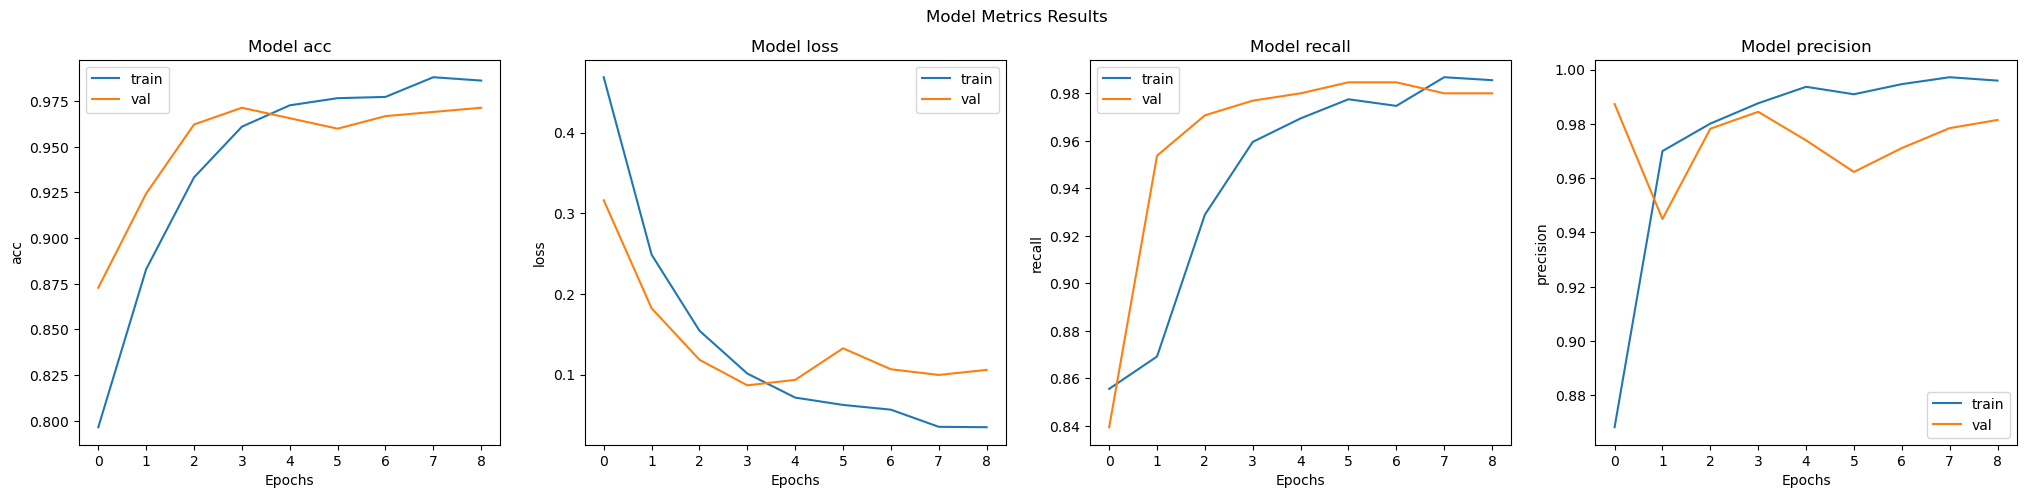

In [298]:
print("Model 5 with updated hyperparamters :\n")
eval_metrics(history5)

In [299]:
train_labels, train_predictions = predict_results(model_5,train_gen)
val_labels, val_predictions = predict_results(model_5,val_gen)

2023-03-25 21:08:40.850418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


Training Confusion Matrices:



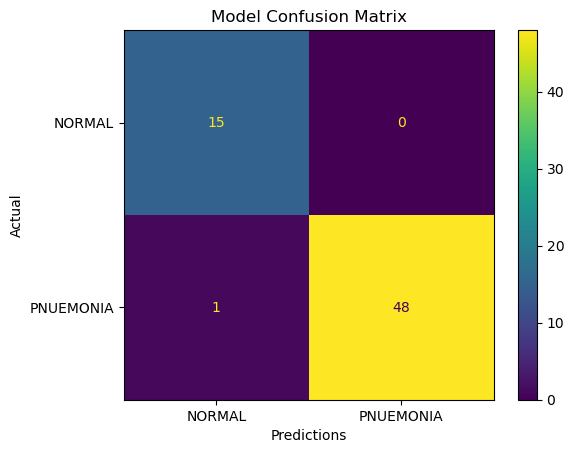

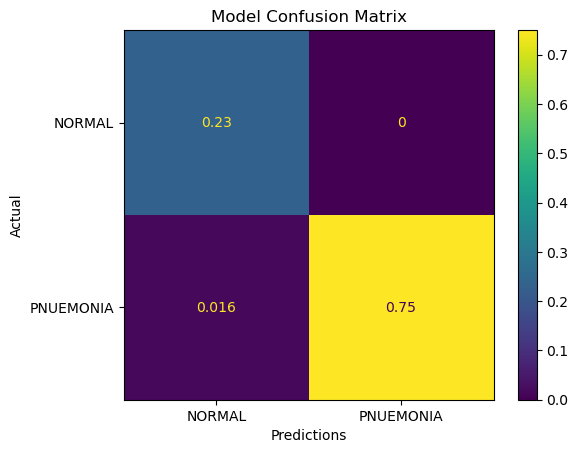

Validation Confusion Matrices:



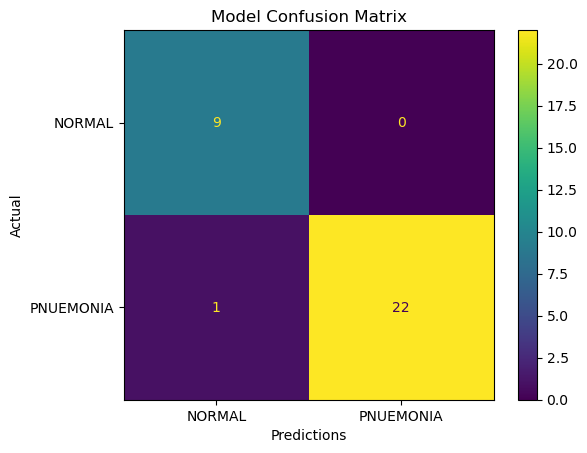

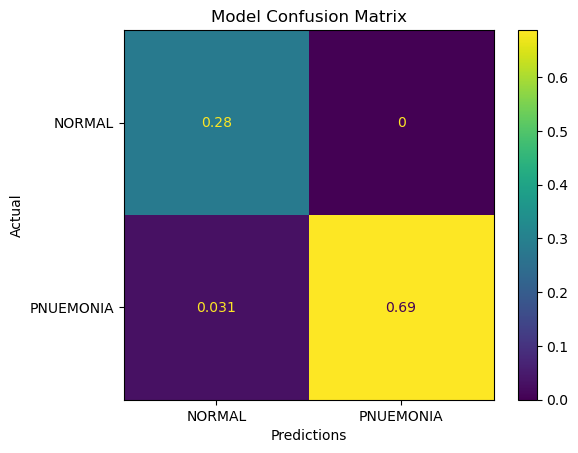

In [300]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [321]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history5)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        15
         1.0       1.00      0.98      0.99        49

    accuracy                           0.98        64
   macro avg       0.97      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64



69/69 [==============================] - 16s 222ms/step - loss: 0.0128 - acc: 0.9954 - recall: 0.9941 - precision: 0.9997
Loss: 0.01275542564690113


In [322]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history5)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95         9
         1.0       1.00      0.96      0.98        23

    accuracy                           0.97        32
   macro avg       0.95      0.98      0.96        32
weighted avg       0.97      0.97      0.97        32



28/28 [==============================] - 3s 111ms/step - loss: 0.1060 - acc: 0.9714 - recall: 0.9799 - precision: 0.9815
Loss: 0.10601130872964859


# Data Augmentation

!(Data Augmentation, YASSINE GHOUZAM, 2017)[https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

Seeing if augmenting the data wi
ll help

In [334]:
datagen = ImageDataGenerator(rescale=1/255,
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = [.1,.2], # Randomly zoom image 
        width_shift_range=[.1,.2],  # randomly shift images horizontally (fraction of total width)
        height_shift_range=[.1,.2],  # randomly shift images vertically (fraction of total height)
        fill_mode = "nearest")  


In [ ]:

train_gen = datagen.flow_from_directory(train_directory,
                                                   target_size = (224, 224),
                                                   batch_size=64,
                                                   classes = ["NORMAL","PNEUMONIA"],
                                                   class_mode = 'binary',
                                                   
                                                   seed = 42)

val_gen = datagen.flow_from_directory(validation_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 64,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42)
test_gen = datagen.flow_from_directory(test_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 64,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42,
                                                      shuffle= False)                                                      